In [1]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
from __future__ import division
import os
import urllib, cStringIO

import pymongo as pm
from PIL import Image
import base64

import numpy as np
from numpy import *
import os
import PIL
from PIL import Image
import base64
import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')
from matplotlib.path import Path
import matplotlib.patches as patches


import cStringIO
import pandas as pd
import pymongo as pm ## first establish ssh tunnel to server where database is running
from matplotlib.path import Path
import matplotlib.patches as patches
from svgpathtools import parse_path

In [2]:
# directory & file hierarchy
exp_path = 'museumdraw'
analysis_dir = os.getcwd()
exp_dir = os.path.abspath(os.path.join(os.getcwd(),'../..','experiments'))
##
sketch_dir = os.path.join(analysis_dir,'sketches')
if not os.path.exists(sketch_dir):
    os.makedirs(sketch_dir)
## dir where we can keep all sketches not binned by category    


In [3]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
experiment_name = "cdm_run_v3"
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['kiddraw']
coll = db[experiment_name]


In [4]:
# wave 1 of data collection (16 classes)
time_threshold = 1510252452134 ## this is the timepoint after which real data started getting collected
all_sessions = coll.distinct('sessionId') ## this returns ALL sessions in this collection. we will then filter on time_threshold
valid_sessions = coll.find({'time':{'$gt': time_threshold}}).distinct('sessionId')
practice_categories = ['square','shape','this circle']
print 'We currently have {} valid sessions from {}.'.format(len(valid_sessions), experiment_name)

We currently have 819 valid sessions from cdm_run_v3.


#### helper functions for svg rendering

In [5]:
def polyline_pathmaker(lines):
    x = []
    y = []

    codes = [Path.MOVETO] # start with moveto command always
    for i,l in enumerate(lines):
        for _i,_l in enumerate(l):
            x.append(_l[0])
            y.append(_l[1])
            if _i<len(l)-1:
                codes.append(Path.LINETO) # keep pen on page
            else:
                if i != len(lines)-1: # final vertex
                    codes.append(Path.MOVETO)
    verts = zip(x,y) 
    return verts, codes

def path_renderer(verts, codes):
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    if len(verts)>0:
        path = Path(verts, codes)
        patch = patches.PathPatch(path, facecolor='none', lw=2)
        ax.add_patch(patch)
        ax.set_xlim(0,1638)
        ax.set_ylim(0,1638) 
        ax.axis('off')
        plt.gca().invert_yaxis() # y values increase as you go down in image
        plt.show()
    else:
        ax.set_xlim(0,1638)
        ax.set_ylim(0,1638)        
        ax.axis('off')
        plt.show()
    plt.savefig()
    plt.close()
    
def flatten(x):
    return [val for sublist in x for val in sublist]

In [6]:
def get_verts_and_codes(svg_list):
    '''
    parse into x,y coordinates and output list of lists of coordinates
    
    '''    
    lines = []
    Verts = []
    Codes = []
    for stroke_ind,stroke in enumerate(svg_list):
        x = []
        y = []
        parsed = parse_path(stroke)
        for i,p in enumerate(parsed):
            if i!=len(parsed)-1: # last line segment
                x.append(p.start.real)
                y.append(p.start.imag)    
            else:
                x.append(p.start.real)
                y.append(p.start.imag)     
                x.append(p.end.real)
                y.append(p.end.imag)
        lines.append(zip(x,y))
        verts, codes = polyline_pathmaker(lines)
        Verts.append(verts)
        Codes.append(codes) 
    return Verts, Codes
    
def make_svg_list(stroke_recs):
    '''
    grab sample drawing's strokes and make a list of svg strings from it
    '''
    svg_list = []
    for single_stroke in stroke_recs:
        svg_string = single_stroke['svg']
        svg_list.append(svg_string)  
        
    return svg_list
    
    
def render_and_save(Verts,
                    Codes,
                    line_width=5,
                    imsize=6,
                    canvas_size=809,
                    session_id='SESSION_ID',
                    age='AGE',
                    trial_num='TRIAL_NUM',
                    category='CATEGORY'):
    
    '''
    input: 
        line_width: how wide of strokes do we want? (int)
        imsize: how big of a picture do we want? (setting the size of the figure) 
        canvas_size: original canvas size on tablet?
        out_path: where do you want to save your images? currently hardcoded below.        
    output:
        rendered sketches into nested directories
    
    '''
    ## where do you want to save your cumulative drawings?
    out_path = os.path.join('./cumulative_drawings','{}_{}'.format(session_id,age),'{}_{}'.format(trial_num,category))
    if not os.path.exists('./cumulative_drawings'):
        os.makedirs('./cumulative_drawings')
    if not os.path.exists(os.path.join('cumulative_drawings','{}_{}'.format(session_id,age))):
        os.makedirs(os.path.join('cumulative_drawings','{}_{}'.format(session_id,age)))

    verts = Verts[0]
    codes = Codes[0]
    for i,verts in enumerate(Verts):
        codes = Codes[i]
        fig = plt.figure(figsize=(imsize,imsize), frameon=False)    
        ax = plt.subplot(111)
        ax.axis('off')
        ax.set_xlim(0,canvas_size)
        ax.set_ylim(0,canvas_size)
        
        # remove padding for xaxis and y axis
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        # remove further paddings
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
        
        ### render sketch so far
        if len(verts)>0:
            path = Path(verts, codes)
            patch = patches.PathPatch(path, facecolor='none', lw=line_width)
            ax.add_patch(patch)
            plt.gca().invert_yaxis() # y values increase as you go down in image
#             plt.show()


        ## save out as png 
        ## maybe to make it not render every single thing, use plt.ioff
        if not os.path.exists(out_path):
            os.makedirs(out_path)
        fname = '{}_{}_{}_{}.png'.format(session_id,trial_num,category,i)
        filepath = os.path.join(out_path,fname)
        print filepath
        
        fig.savefig(filepath, bbox_inches='tight', pad_inches=0.0)
        plt.close(fig)        

Great! Number of drawings made by this person: 8
./cumulative_drawings/cdm_run_v31525887854758_age6/0_square/cdm_run_v31525887854758_0_square_0.png
./cumulative_drawings/cdm_run_v31525887854758_age6/1_shape/cdm_run_v31525887854758_1_shape_0.png
./cumulative_drawings/cdm_run_v31525887854758_age6/2_this circle/cdm_run_v31525887854758_2_this circle_0.png
Great! Number of drawings made by this person: 3
./cumulative_drawings/cdm_run_v31525889224904_age2/0_square/cdm_run_v31525889224904_0_square_0.png
./cumulative_drawings/cdm_run_v31525889224904_age2/1_shape/cdm_run_v31525889224904_1_shape_0.png
./cumulative_drawings/cdm_run_v31525889224904_age2/1_shape/cdm_run_v31525889224904_1_shape_1.png
./cumulative_drawings/cdm_run_v31525889224904_age2/1_shape/cdm_run_v31525889224904_1_shape_2.png
./cumulative_drawings/cdm_run_v31525889224904_age2/1_shape/cdm_run_v31525889224904_1_shape_3.png
./cumulative_drawings/cdm_run_v31525889224904_age2/1_shape/cdm_run_v31525889224904_1_shape_4.png
./cumulative_

Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31525901322190_age2/0_square/cdm_run_v31525901322190_0_square_0.png
./cumulative_drawings/cdm_run_v31525901322190_age2/0_square/cdm_run_v31525901322190_0_square_1.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 8
./cumulative_drawings/cdm_run_v31525901714819_age3/0_square/cdm_run_v31525901714819_0_square_0.png
./cumulative_drawings/cdm_run_v31525901714819_age3/0_square/cdm_run_v31525901714819_0_square_1.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31525902126553_adult/0_square/cdm_run_v31525902126553_0_square_0.png
./cumulative_drawings/cdm_run_v31525902126553_adult/1_shape/cdm_run_v31525902126553_1_shape_0.png
./cumulative_drawings/c

Great! Number of drawings made by this person: 6
./cumulative_drawings/cdm_run_v31525992411710_age3/0_square/cdm_run_v31525992411710_0_square_0.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31525992682386_age3/0_square/cdm_run_v31525992682386_0_square_0.png
./cumulative_drawings/cdm_run_v31525992682386_age3/0_square/cdm_run_v31525992682386_0_square_1.png
./cumulative_drawings/cdm_run_v31525992682386_age3/0_square/cdm_run_v31525992682386_0_square_2.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 6
./cumulative_drawings/cdm_run_v31525993726883_age9/0_square/cdm_run_v31525993726883_0_square_0.png
./cumulative_drawings/cdm_run_v31525993726883_age9/0_square/cdm_run_v31525993726883_0_square_1.png
./cumulative_drawings/cd

Great! Number of drawings made by this person: 10
Oops, something went wrong! Here is the error:

Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31526067194650_age2/0_square/cdm_run_v31526067194650_0_square_0.png
./cumulative_drawings/cdm_run_v31526067194650_age2/1_shape/cdm_run_v31526067194650_1_shape_0.png
./cumulative_drawings/cdm_run_v31526067194650_age2/1_shape/cdm_run_v31526067194650_1_shape_1.png
./cumulative_drawings/cdm_run_v31526067194650_age2/1_shape/cdm_run_v31526067194650_1_shape_2.png
./cumulative_drawings/cdm_run_v31526067194650_age2/2_this circle/cdm_run_v31526067194650_2_this circle_0.png
Great! Number of drawings made by this person: 7
./cumulative_drawings/cdm_run_v31526072349961_age5/0_square/cdm_run_v31526072349961_0_square_0.png
./cumulative_drawings/cdm_run_v31526072349961_age5/0_square/cdm_run_v31526072349961_0_square_1.png
./cumulative_drawings/cdm_run_v31526072349961_age5/1_shape/cdm_run_v31526072349961_1_shape_0.png
./cumulat

/Users/zixianchai/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


./cumulative_drawings/cdm_run_v31526078151101_age3/0_square/cdm_run_v31526078151101_0_square_0.png
./cumulative_drawings/cdm_run_v31526078151101_age3/0_square/cdm_run_v31526078151101_0_square_1.png
./cumulative_drawings/cdm_run_v31526078151101_age3/0_square/cdm_run_v31526078151101_0_square_2.png
./cumulative_drawings/cdm_run_v31526078151101_age3/0_square/cdm_run_v31526078151101_0_square_3.png
./cumulative_drawings/cdm_run_v31526078151101_age3/0_square/cdm_run_v31526078151101_0_square_4.png
./cumulative_drawings/cdm_run_v31526078151101_age3/0_square/cdm_run_v31526078151101_0_square_5.png
./cumulative_drawings/cdm_run_v31526078151101_age3/0_square/cdm_run_v31526078151101_0_square_6.png
./cumulative_drawings/cdm_run_v31526078151101_age3/0_square/cdm_run_v31526078151101_0_square_7.png
./cumulative_drawings/cdm_run_v31526078151101_age3/0_square/cdm_run_v31526078151101_0_square_8.png
./cumulative_drawings/cdm_run_v31526078151101_age3/0_square/cdm_run_v31526078151101_0_square_9.png
./cumulati

Great! Number of drawings made by this person: 6
./cumulative_drawings/cdm_run_v31526151383057_age10/0_square/cdm_run_v31526151383057_0_square_0.png
./cumulative_drawings/cdm_run_v31526151383057_age10/0_square/cdm_run_v31526151383057_0_square_1.png
./cumulative_drawings/cdm_run_v31526151383057_age10/1_shape/cdm_run_v31526151383057_1_shape_0.png
./cumulative_drawings/cdm_run_v31526151383057_age10/2_this circle/cdm_run_v31526151383057_2_this circle_0.png
Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31526152332221_age10/0_square/cdm_run_v31526152332221_0_square_0.png
./cumulative_drawings/cdm_run_v31526152332221_age10/0_square/cdm_run_v31526152332221_0_square_1.png
./cumulative_drawings/cdm_run_v31526152332221_age10/0_square/cdm_run_v31526152332221_0_square_2.png
./cumulative_drawings/cdm_run_v31526152332221_age10/1_shape/cdm_run_v31526152332221_1_shape_0.png
./cumulative_drawings/cdm_run_v31526152332221_age10/2_this circle/cdm_run_v31526152332221_2_thi

./cumulative_drawings/cdm_run_v31526155956525_age9/0_square/cdm_run_v31526155956525_0_square_0.png
./cumulative_drawings/cdm_run_v31526155956525_age9/1_shape/cdm_run_v31526155956525_1_shape_0.png
./cumulative_drawings/cdm_run_v31526155956525_age9/2_this circle/cdm_run_v31526155956525_2_this circle_0.png
Great! Number of drawings made by this person: 11
./cumulative_drawings/cdm_run_v31526157427450_age5/0_square/cdm_run_v31526157427450_0_square_0.png
./cumulative_drawings/cdm_run_v31526157427450_age5/1_shape/cdm_run_v31526157427450_1_shape_0.png
./cumulative_drawings/cdm_run_v31526157427450_age5/2_this circle/cdm_run_v31526157427450_2_this circle_0.png
./cumulative_drawings/cdm_run_v31526157427450_age5/2_this circle/cdm_run_v31526157427450_2_this circle_1.png
Great! Number of drawings made by this person: 9
./cumulative_drawings/cdm_run_v31526157685006_age6/0_square/cdm_run_v31526157685006_0_square_0.png
./cumulative_drawings/cdm_run_v31526157685006_age6/0_square/cdm_run_v31526157685006

Great! Number of drawings made by this person: 4
./cumulative_drawings/cdm_run_v31526163636798_age2/0_square/cdm_run_v31526163636798_0_square_0.png
./cumulative_drawings/cdm_run_v31526163636798_age2/0_square/cdm_run_v31526163636798_0_square_1.png
./cumulative_drawings/cdm_run_v31526163636798_age2/0_square/cdm_run_v31526163636798_0_square_2.png
./cumulative_drawings/cdm_run_v31526163636798_age2/0_square/cdm_run_v31526163636798_0_square_3.png
./cumulative_drawings/cdm_run_v31526163636798_age2/0_square/cdm_run_v31526163636798_0_square_4.png
./cumulative_drawings/cdm_run_v31526163636798_age2/0_square/cdm_run_v31526163636798_0_square_5.png
./cumulative_drawings/cdm_run_v31526163636798_age2/0_square/cdm_run_v31526163636798_0_square_6.png
./cumulative_drawings/cdm_run_v31526163636798_age2/0_square/cdm_run_v31526163636798_0_square_7.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this per

./cumulative_drawings/cdm_run_v31526245726886_age3/1_shape/cdm_run_v31526245726886_1_shape_0.png
./cumulative_drawings/cdm_run_v31526245726886_age3/1_shape/cdm_run_v31526245726886_1_shape_1.png
./cumulative_drawings/cdm_run_v31526245726886_age3/1_shape/cdm_run_v31526245726886_1_shape_2.png
./cumulative_drawings/cdm_run_v31526245726886_age3/2_this circle/cdm_run_v31526245726886_2_this circle_0.png
Great! Number of drawings made by this person: 10
./cumulative_drawings/cdm_run_v31526247467722_age9/0_square/cdm_run_v31526247467722_0_square_0.png
./cumulative_drawings/cdm_run_v31526247467722_age9/0_square/cdm_run_v31526247467722_0_square_1.png
./cumulative_drawings/cdm_run_v31526247467722_age9/0_square/cdm_run_v31526247467722_0_square_2.png
./cumulative_drawings/cdm_run_v31526247467722_age9/1_shape/cdm_run_v31526247467722_1_shape_0.png
./cumulative_drawings/cdm_run_v31526247467722_age9/2_this circle/cdm_run_v31526247467722_2_this circle_0.png
Great! Number of drawings made by this person: 

./cumulative_drawings/cdm_run_v31526409936551_age6/0_square/cdm_run_v31526409936551_0_square_3.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31526410266990_adult/0_square/cdm_run_v31526410266990_0_square_0.png
./cumulative_drawings/cdm_run_v31526410266990_adult/0_square/cdm_run_v31526410266990_0_square_1.png
./cumulative_drawings/cdm_run_v31526410266990_adult/1_shape/cdm_run_v31526410266990_1_shape_0.png
./cumulative_drawings/cdm_run_v31526410266990_adult/1_shape/cdm_run_v31526410266990_1_shape_1.png
./cumulative_drawings/cdm_run_v31526410266990_adult/1_shape/cdm_run_v31526410266990_1_shape_2.png
./cumulative_drawings/cdm_run_v31526410266990_adult/1_shape/cdm_run_v31526410266990_1_shape_3.png
./cumulative_drawings/cdm_run_v31526410266990_adult/2_this circle/cdm_run_v31526410266990_2_this circle_0.png
Great! Number of drawings made b

./cumulative_drawings/cdm_run_v31526420267473_age5/2_this circle/cdm_run_v31526420267473_2_this circle_4.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 5
./cumulative_drawings/cdm_run_v31526420360572_age5/0_square/cdm_run_v31526420360572_0_square_0.png
./cumulative_drawings/cdm_run_v31526420360572_age5/1_shape/cdm_run_v31526420360572_1_shape_0.png
./cumulative_drawings/cdm_run_v31526420360572_age5/1_shape/cdm_run_v31526420360572_1_shape_1.png
./cumulative_drawings/cdm_run_v31526420360572_age5/1_shape/cdm_run_v31526420360572_1_shape_2.png
./cumulative_drawings/cdm_run_v31526420360572_age5/1_shape/cdm_run_v31526420360572_1_shape_3.png
./cumulative_drawings/cdm_run_v31526420360572_age5/1_shape/cdm_run_v31526420360572_1_shape_4.png
./cumulative_drawings/cdm_run_v31526420360572_age5/2_this circle/cdm_run_v31526420360572_2_this circle_0.png
./cumulative_drawings/cdm_run_v3

./cumulative_drawings/cdm_run_v31526492679058_age2/0_square/cdm_run_v31526492679058_0_square_0.png
./cumulative_drawings/cdm_run_v31526492679058_age2/0_square/cdm_run_v31526492679058_0_square_1.png
./cumulative_drawings/cdm_run_v31526492679058_age2/0_square/cdm_run_v31526492679058_0_square_2.png
./cumulative_drawings/cdm_run_v31526492679058_age2/0_square/cdm_run_v31526492679058_0_square_3.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 9
./cumulative_drawings/cdm_run_v31526493024418_age2/0_square/cdm_run_v31526493024418_0_square_0.png
./cumulative_drawings/cdm_run_v31526493024418_age2/1_shape/cdm_run_v31526493024418_1_shape_0.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31526493522883_age2/0_square/cdm_run_v315264

./cumulative_drawings/cdm_run_v31526499554039_age5/2_this circle/cdm_run_v31526499554039_2_this circle_0.png
./cumulative_drawings/cdm_run_v31526499554039_age5/2_this circle/cdm_run_v31526499554039_2_this circle_1.png
Great! Number of drawings made by this person: 4
./cumulative_drawings/cdm_run_v31526500472039_age3/0_square/cdm_run_v31526500472039_0_square_0.png
./cumulative_drawings/cdm_run_v31526500472039_age3/0_square/cdm_run_v31526500472039_0_square_1.png
./cumulative_drawings/cdm_run_v31526500472039_age3/0_square/cdm_run_v31526500472039_0_square_2.png
./cumulative_drawings/cdm_run_v31526500472039_age3/1_shape/cdm_run_v31526500472039_1_shape_0.png
./cumulative_drawings/cdm_run_v31526500472039_age3/1_shape/cdm_run_v31526500472039_1_shape_1.png
./cumulative_drawings/cdm_run_v31526500472039_age3/1_shape/cdm_run_v31526500472039_1_shape_2.png
./cumulative_drawings/cdm_run_v31526500472039_age3/1_shape/cdm_run_v31526500472039_1_shape_3.png
./cumulative_drawings/cdm_run_v31526500472039_ag

./cumulative_drawings/cdm_run_v31526506411620_age6/1_shape/cdm_run_v31526506411620_1_shape_0.png
./cumulative_drawings/cdm_run_v31526506411620_age6/2_this circle/cdm_run_v31526506411620_2_this circle_0.png
./cumulative_drawings/cdm_run_v31526506411620_age6/2_this circle/cdm_run_v31526506411620_2_this circle_1.png
Great! Number of drawings made by this person: 4
./cumulative_drawings/cdm_run_v31526506824890_age4/0_square/cdm_run_v31526506824890_0_square_0.png
./cumulative_drawings/cdm_run_v31526506824890_age4/1_shape/cdm_run_v31526506824890_1_shape_0.png
./cumulative_drawings/cdm_run_v31526506824890_age4/1_shape/cdm_run_v31526506824890_1_shape_1.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31526507469435_age4/0_square/cdm_run_v31526507469435_0_square_0.png
./cumulative_drawings/cdm_run_v31526507469435_age4/0_square/cdm_run_v31526507

./cumulative_drawings/cdm_run_v31526580344270_adult/0_square/cdm_run_v31526580344270_0_square_0.png
./cumulative_drawings/cdm_run_v31526580344270_adult/1_shape/cdm_run_v31526580344270_1_shape_0.png
Oops, something went wrong! Here is the error:

Great! Number of drawings made by this person: 11
Oops, something went wrong! Here is the error:

Great! Number of drawings made by this person: 4
./cumulative_drawings/cdm_run_v31526581002319_age2/0_square/cdm_run_v31526581002319_0_square_0.png
./cumulative_drawings/cdm_run_v31526581002319_age2/1_shape/cdm_run_v31526581002319_1_shape_0.png
./cumulative_drawings/cdm_run_v31526581002319_age2/2_this circle/cdm_run_v31526581002319_2_this circle_0.png
Great! Number of drawings made by this person: 7
./cumulative_drawings/cdm_run_v31526581096926_age6/0_square/cdm_run_v31526581096926_0_square_0.png
./cumulative_drawings/cdm_run_v31526581096926_age6/1_shape/cdm_run_v31526581096926_1_shape_0.png
./cumulative_drawings/cdm_run_v31526581096926_age6/2_this

./cumulative_drawings/cdm_run_v31526588910402_adult/0_square/cdm_run_v31526588910402_0_square_15.png
./cumulative_drawings/cdm_run_v31526588910402_adult/0_square/cdm_run_v31526588910402_0_square_16.png
./cumulative_drawings/cdm_run_v31526588910402_adult/0_square/cdm_run_v31526588910402_0_square_17.png
./cumulative_drawings/cdm_run_v31526588910402_adult/0_square/cdm_run_v31526588910402_0_square_18.png
./cumulative_drawings/cdm_run_v31526588910402_adult/0_square/cdm_run_v31526588910402_0_square_19.png
./cumulative_drawings/cdm_run_v31526588910402_adult/0_square/cdm_run_v31526588910402_0_square_20.png
./cumulative_drawings/cdm_run_v31526588910402_adult/0_square/cdm_run_v31526588910402_0_square_21.png
./cumulative_drawings/cdm_run_v31526588910402_adult/0_square/cdm_run_v31526588910402_0_square_22.png
./cumulative_drawings/cdm_run_v31526588910402_adult/0_square/cdm_run_v31526588910402_0_square_23.png
./cumulative_drawings/cdm_run_v31526588910402_adult/0_square/cdm_run_v31526588910402_0_squa

Great! Number of drawings made by this person: 4
./cumulative_drawings/cdm_run_v31526598587970_age3/0_square/cdm_run_v31526598587970_0_square_0.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31526598717979_age7/0_square/cdm_run_v31526598717979_0_square_0.png
./cumulative_drawings/cdm_run_v31526598717979_age7/0_square/cdm_run_v31526598717979_0_square_1.png
./cumulative_drawings/cdm_run_v31526598717979_age7/1_shape/cdm_run_v31526598717979_1_shape_0.png
./cumulative_drawings/cdm_run_v31526598717979_age7/1_shape/cdm_run_v31526598717979_1_shape_1.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 6
./cumulative_drawings/cdm_run_v31526598908203_age7/0_square/cdm_run_v31526598908203_0_square_0.png
./cumulative_drawings/cdm_ru

Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31526673903441_age4/0_square/cdm_run_v31526673903441_0_square_0.png
./cumulative_drawings/cdm_run_v31526673903441_age4/1_shape/cdm_run_v31526673903441_1_shape_0.png
./cumulative_drawings/cdm_run_v31526673903441_age4/1_shape/cdm_run_v31526673903441_1_shape_1.png
./cumulative_drawings/cdm_run_v31526673903441_age4/1_shape/cdm_run_v31526673903441_1_shape_2.png
./cumulative_drawings/cdm_run_v31526673903441_age4/1_shape/cdm_run_v31526673903441_1_shape_3.png
./cumulative_drawings/cdm_run_v31526673903441_age4/1_shape/cdm_run_v31526673903441_1_shape_4.png
./cumulative_drawings/cdm_run_v31526673903441_age4/1_shape/cdm_run_v31526673903441_1_shape_5.png
./cumulative_drawings/cdm_run_v31526673903441_age4/1_shape/cdm_run_v31526673903441_1_shape_6.png
./cumulative_drawings/cdm_run_v31526673903441_age4/1_shape/cdm_run_v31526673903441_1_shape_7.png
./cumulative_drawings/cdm_run_v31526673903441_age4/1_shape/cdm_run_v3152667

./cumulative_drawings/cdm_run_v31526681463221_age5/1_shape/cdm_run_v31526681463221_1_shape_0.png
./cumulative_drawings/cdm_run_v31526681463221_age5/2_this circle/cdm_run_v31526681463221_2_this circle_0.png
./cumulative_drawings/cdm_run_v31526681463221_age5/2_this circle/cdm_run_v31526681463221_2_this circle_1.png
Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31526682177815_adult/0_square/cdm_run_v31526682177815_0_square_0.png
./cumulative_drawings/cdm_run_v31526682177815_adult/1_shape/cdm_run_v31526682177815_1_shape_0.png
./cumulative_drawings/cdm_run_v31526682177815_adult/2_this circle/cdm_run_v31526682177815_2_this circle_0.png
Great! Number of drawings made by this person: 11
./cumulative_drawings/cdm_run_v31526749199535_adult/0_square/cdm_run_v31526749199535_0_square_0.png
./cumulative_drawings/cdm_run_v31526749199535_adult/1_shape/cdm_run_v31526749199535_1_shape_0.png
./cumulative_drawings/cdm_run_v31526749199535_adult/1_shape/cdm_run_v3152674919

Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 3
Oops, something went wrong! Here is the error:

Great! Number of drawings made by this person: 8
./cumulative_drawings/cdm_run_v31526759675535_age6/0_square/cdm_run_v31526759675535_0_square_0.png
./cumulative_drawings/cdm_run_v31526759675535_age6/1_shape/cdm_run_v31526759675535_1_shape_0.png
./cumulative_drawings/cdm_run_v31526759675535_age6/2_this circle/cdm_run_v31526759675535_2_this circle_0.png
Great! Number of drawings made by this person: 6
./cumulative_drawings/cdm_run_v31526760363848_age3/0_square/cdm_run_v31526760363848_0_square_0.png
./cumulative_drawings/cdm_run_v31526760363848_age3/1_shape/cdm_run_v31526760363848_1_shape_0.png
./cumulative_drawings/cdm_run_v31526760363848_age3/2_this circle/cdm_run_v31526760363848_2_this circle_0.png
Great! Number of drawings made by this person: 5
./cumulative_drawings/cdm_run

Great! Number of drawings made by this person: 4
./cumulative_drawings/cdm_run_v31526766939394_age3/0_square/cdm_run_v31526766939394_0_square_0.png
./cumulative_drawings/cdm_run_v31526766939394_age3/0_square/cdm_run_v31526766939394_0_square_1.png
./cumulative_drawings/cdm_run_v31526766939394_age3/0_square/cdm_run_v31526766939394_0_square_2.png
./cumulative_drawings/cdm_run_v31526766939394_age3/0_square/cdm_run_v31526766939394_0_square_3.png
Oops, something went wrong! Here is the error:

Great! Number of drawings made by this person: 5
./cumulative_drawings/cdm_run_v31526767554598_age3/0_square/cdm_run_v31526767554598_0_square_0.png
./cumulative_drawings/cdm_run_v31526767554598_age3/0_square/cdm_run_v31526767554598_0_square_1.png
./cumulative_drawings/cdm_run_v31526767554598_age3/0_square/cdm_run_v31526767554598_0_square_2.png
./cumulative_drawings/cdm_run_v31526767554598_age3/0_square/cdm_run_v31526767554598_0_square_3.png
./cumulative_drawings/cdm_run_v31526767554598_age3/0_square/cd

./cumulative_drawings/cdm_run_v31527709199308_adult/1_shape/cdm_run_v31527709199308_1_shape_0.png
./cumulative_drawings/cdm_run_v31527709199308_adult/2_this circle/cdm_run_v31527709199308_2_this circle_0.png
Great! Number of drawings made by this person: 7
Oops, something went wrong! Here is the error:

Great! Number of drawings made by this person: 3
./cumulative_drawings/cdm_run_v31527717845451_age4/0_square/cdm_run_v31527717845451_0_square_0.png
./cumulative_drawings/cdm_run_v31527717845451_age4/1_shape/cdm_run_v31527717845451_1_shape_0.png
./cumulative_drawings/cdm_run_v31527717845451_age4/2_this circle/cdm_run_v31527717845451_2_this circle_0.png
./cumulative_drawings/cdm_run_v31527717845451_age4/2_this circle/cdm_run_v31527717845451_2_this circle_1.png
./cumulative_drawings/cdm_run_v31527717845451_age4/2_this circle/cdm_run_v31527717845451_2_this circle_2.png
./cumulative_drawings/cdm_run_v31527717845451_age4/2_this circle/cdm_run_v31527717845451_2_this circle_3.png
./cumulative_d

./cumulative_drawings/cdm_run_v31527788044704_age7/1_shape/cdm_run_v31527788044704_1_shape_18.png
./cumulative_drawings/cdm_run_v31527788044704_age7/1_shape/cdm_run_v31527788044704_1_shape_19.png
./cumulative_drawings/cdm_run_v31527788044704_age7/2_this circle/cdm_run_v31527788044704_2_this circle_0.png
Great! Number of drawings made by this person: 3
./cumulative_drawings/cdm_run_v31527788644727_age5/0_square/cdm_run_v31527788644727_0_square_0.png
./cumulative_drawings/cdm_run_v31527788644727_age5/0_square/cdm_run_v31527788644727_0_square_1.png
./cumulative_drawings/cdm_run_v31527788644727_age5/0_square/cdm_run_v31527788644727_0_square_2.png
./cumulative_drawings/cdm_run_v31527788644727_age5/1_shape/cdm_run_v31527788644727_1_shape_0.png
./cumulative_drawings/cdm_run_v31527788644727_age5/2_this circle/cdm_run_v31527788644727_2_this circle_0.png
Great! Number of drawings made by this person: 9
./cumulative_drawings/cdm_run_v31527789844695_age7/0_square/cdm_run_v31527789844695_0_square_0

./cumulative_drawings/cdm_run_v31527801844607_age3/0_square/cdm_run_v31527801844607_0_square_0.png
./cumulative_drawings/cdm_run_v31527801844607_age3/0_square/cdm_run_v31527801844607_0_square_1.png
./cumulative_drawings/cdm_run_v31527801844607_age3/0_square/cdm_run_v31527801844607_0_square_2.png
./cumulative_drawings/cdm_run_v31527801844607_age3/0_square/cdm_run_v31527801844607_0_square_3.png
./cumulative_drawings/cdm_run_v31527801844607_age3/0_square/cdm_run_v31527801844607_0_square_4.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 5
./cumulative_drawings/cdm_run_v31527802444465_age5/0_square/cdm_run_v31527802444465_0_square_0.png
./cumulative_drawings/cdm_run_v31527802444465_age5/1_shape/cdm_run_v31527802444465_1_shape_0.png
./cumulative_drawings/cdm_run_v31527802444465_age5/1_shape/cdm_run_v31527802444465_1_shape_1.png
./cumulative_drawings/cdm_run_v31527802444465_

Great! Number of drawings made by this person: 4
./cumulative_drawings/cdm_run_v31527885599398_age2/0_square/cdm_run_v31527885599398_0_square_0.png
./cumulative_drawings/cdm_run_v31527885599398_age2/0_square/cdm_run_v31527885599398_0_square_1.png
./cumulative_drawings/cdm_run_v31527885599398_age2/0_square/cdm_run_v31527885599398_0_square_2.png
./cumulative_drawings/cdm_run_v31527885599398_age2/0_square/cdm_run_v31527885599398_0_square_3.png
./cumulative_drawings/cdm_run_v31527885599398_age2/0_square/cdm_run_v31527885599398_0_square_4.png
./cumulative_drawings/cdm_run_v31527885599398_age2/1_shape/cdm_run_v31527885599398_1_shape_0.png
./cumulative_drawings/cdm_run_v31527885599398_age2/1_shape/cdm_run_v31527885599398_1_shape_1.png
./cumulative_drawings/cdm_run_v31527885599398_age2/1_shape/cdm_run_v31527885599398_1_shape_2.png
./cumulative_drawings/cdm_run_v31527885599398_age2/1_shape/cdm_run_v31527885599398_1_shape_3.png
./cumulative_drawings/cdm_run_v31527885599398_age2/1_shape/cdm_run_v

./cumulative_drawings/cdm_run_v31527895799232_age4/0_square/cdm_run_v31527895799232_0_square_0.png
./cumulative_drawings/cdm_run_v31527895799232_age4/0_square/cdm_run_v31527895799232_0_square_1.png
./cumulative_drawings/cdm_run_v31527895799232_age4/1_shape/cdm_run_v31527895799232_1_shape_0.png
./cumulative_drawings/cdm_run_v31527895799232_age4/1_shape/cdm_run_v31527895799232_1_shape_1.png
./cumulative_drawings/cdm_run_v31527895799232_age4/1_shape/cdm_run_v31527895799232_1_shape_2.png
./cumulative_drawings/cdm_run_v31527895799232_age4/1_shape/cdm_run_v31527895799232_1_shape_3.png
./cumulative_drawings/cdm_run_v31527895799232_age4/2_this circle/cdm_run_v31527895799232_2_this circle_0.png
Great! Number of drawings made by this person: 5
Oops, something went wrong! Here is the error:

Great! Number of drawings made by this person: 3
Oops, something went wrong! Here is the error:

Great! Number of drawings made by this person: 12
Oops, something went wrong! Here is the error:

Great! Number

Oops, something went wrong! Here is the error:

Great! Number of drawings made by this person: 4
./cumulative_drawings/cdm_run_v31527967589959_adult/0_square/cdm_run_v31527967589959_0_square_0.png
./cumulative_drawings/cdm_run_v31527967589959_adult/1_shape/cdm_run_v31527967589959_1_shape_0.png
./cumulative_drawings/cdm_run_v31527967589959_adult/2_this circle/cdm_run_v31527967589959_2_this circle_0.png
Great! Number of drawings made by this person: 6
./cumulative_drawings/cdm_run_v31527968718676_age2/0_square/cdm_run_v31527968718676_0_square_0.png
./cumulative_drawings/cdm_run_v31527968718676_age2/0_square/cdm_run_v31527968718676_0_square_1.png
./cumulative_drawings/cdm_run_v31527968718676_age2/0_square/cdm_run_v31527968718676_0_square_2.png
./cumulative_drawings/cdm_run_v31527968718676_age2/0_square/cdm_run_v31527968718676_0_square_3.png
./cumulative_drawings/cdm_run_v31527968718676_age2/0_square/cdm_run_v31527968718676_0_square_4.png
./cumulative_drawings/cdm_run_v31527968718676_age2/

./cumulative_drawings/cdm_run_v31527974237867_age6/1_shape/cdm_run_v31527974237867_1_shape_4.png
./cumulative_drawings/cdm_run_v31527974237867_age6/1_shape/cdm_run_v31527974237867_1_shape_5.png
./cumulative_drawings/cdm_run_v31527974237867_age6/2_this circle/cdm_run_v31527974237867_2_this circle_0.png
./cumulative_drawings/cdm_run_v31527974237867_age6/2_this circle/cdm_run_v31527974237867_2_this circle_1.png
./cumulative_drawings/cdm_run_v31527974237867_age6/2_this circle/cdm_run_v31527974237867_2_this circle_2.png
Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31527974399147_age6/0_square/cdm_run_v31527974399147_0_square_0.png
./cumulative_drawings/cdm_run_v31527974399147_age6/1_shape/cdm_run_v31527974399147_1_shape_0.png
./cumulative_drawings/cdm_run_v31527974399147_age6/1_shape/cdm_run_v31527974399147_1_shape_1.png
./cumulative_drawings/cdm_run_v31527974399147_age6/1_shape/cdm_run_v31527974399147_1_shape_2.png
./cumulative_drawings/cdm_run_v31527974

./cumulative_drawings/cdm_run_v31527980064618_age4/1_shape/cdm_run_v31527980064618_1_shape_2.png
./cumulative_drawings/cdm_run_v31527980064618_age4/1_shape/cdm_run_v31527980064618_1_shape_3.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31527980493619_adult/0_square/cdm_run_v31527980493619_0_square_0.png
./cumulative_drawings/cdm_run_v31527980493619_adult/1_shape/cdm_run_v31527980493619_1_shape_0.png
./cumulative_drawings/cdm_run_v31527980493619_adult/1_shape/cdm_run_v31527980493619_1_shape_1.png
./cumulative_drawings/cdm_run_v31527980493619_adult/2_this circle/cdm_run_v31527980493619_2_this circle_0.png
Great! Number of drawings made by this person: 4
./cumulative_drawings/cdm_run_v31527980737934_age3/0_square/cdm_run_v31527980737934_0_square_0.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array wit

./cumulative_drawings/cdm_run_v31528056367003_adult/2_this circle/cdm_run_v31528056367003_2_this circle_0.png
Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31528056599279_age10/0_square/cdm_run_v31528056599279_0_square_0.png
./cumulative_drawings/cdm_run_v31528056599279_age10/1_shape/cdm_run_v31528056599279_1_shape_0.png
./cumulative_drawings/cdm_run_v31528056599279_age10/2_this circle/cdm_run_v31528056599279_2_this circle_0.png
Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31528057199304_adult/0_square/cdm_run_v31528057199304_0_square_0.png
Oops, something went wrong! Here is the error:

Great! Number of drawings made by this person: 8
./cumulative_drawings/cdm_run_v31528057652800_adult/0_square/cdm_run_v31528057652800_0_square_0.png
./cumulative_drawings/cdm_run_v31528057652800_adult/0_square/cdm_run_v31528057652800_0_square_1.png
./cumulative_drawings/cdm_run_v31528057652800_adult/1_shape/cdm_run_v31528057652800_1

Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31528063199159_age3/0_square/cdm_run_v31528063199159_0_square_0.png
./cumulative_drawings/cdm_run_v31528063199159_age3/1_shape/cdm_run_v31528063199159_1_shape_0.png
./cumulative_drawings/cdm_run_v31528063199159_age3/1_shape/cdm_run_v31528063199159_1_shape_1.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 9
./cumulative_drawings/cdm_run_v31528063799169_age3/0_square/cdm_run_v31528063799169_0_square_0.png
./cumulative_drawings/cdm_run_v31528063799169_age3/0_square/cdm_run_v31528063799169_0_square_1.png
./cumulative_drawings/cdm_run_v31528063799169_age3/1_shape/cdm_run_v31528063799169_1_shape_0.png
./cumulative_drawings/cdm_run_v31528063799169_age3/1_shape/cdm_run_v31528063799169_1_shape_1.png
./cumulative_drawings/cdm_run_v31528063799169_age3/1_shape/cdm_run_v31528063799169_1_shape_2.png
./

./cumulative_drawings/cdm_run_v31528066292174_age2/0_square/cdm_run_v31528066292174_0_square_4.png
./cumulative_drawings/cdm_run_v31528066292174_age2/0_square/cdm_run_v31528066292174_0_square_5.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 4
./cumulative_drawings/cdm_run_v31528066515472_age2/0_square/cdm_run_v31528066515472_0_square_0.png
./cumulative_drawings/cdm_run_v31528066515472_age2/0_square/cdm_run_v31528066515472_0_square_1.png
./cumulative_drawings/cdm_run_v31528066515472_age2/1_shape/cdm_run_v31528066515472_1_shape_0.png
./cumulative_drawings/cdm_run_v31528066515472_age2/2_this circle/cdm_run_v31528066515472_2_this circle_0.png
./cumulative_drawings/cdm_run_v31528066515472_age2/2_this circle/cdm_run_v31528066515472_2_this circle_1.png
./cumulative_drawings/cdm_run_v31528066515472_age2/2_this circle/cdm_run_v31528066515472_2_this circle_2.png
./cumulative_d

Great! Number of drawings made by this person: 10
./cumulative_drawings/cdm_run_v31528135799225_age4/0_square/cdm_run_v31528135799225_0_square_0.png
./cumulative_drawings/cdm_run_v31528135799225_age4/0_square/cdm_run_v31528135799225_0_square_1.png
./cumulative_drawings/cdm_run_v31528135799225_age4/0_square/cdm_run_v31528135799225_0_square_2.png
./cumulative_drawings/cdm_run_v31528135799225_age4/1_shape/cdm_run_v31528135799225_1_shape_0.png
./cumulative_drawings/cdm_run_v31528135799225_age4/2_this circle/cdm_run_v31528135799225_2_this circle_0.png
./cumulative_drawings/cdm_run_v31528135799225_age4/2_this circle/cdm_run_v31528135799225_2_this circle_1.png
./cumulative_drawings/cdm_run_v31528135799225_age4/2_this circle/cdm_run_v31528135799225_2_this circle_2.png
./cumulative_drawings/cdm_run_v31528135799225_age4/2_this circle/cdm_run_v31528135799225_2_this circle_3.png
./cumulative_drawings/cdm_run_v31528135799225_age4/2_this circle/cdm_run_v31528135799225_2_this circle_4.png
Great! Numb

./cumulative_drawings/cdm_run_v31528148156599_age3/1_shape/cdm_run_v31528148156599_1_shape_4.png
./cumulative_drawings/cdm_run_v31528148156599_age3/1_shape/cdm_run_v31528148156599_1_shape_5.png
./cumulative_drawings/cdm_run_v31528148156599_age3/1_shape/cdm_run_v31528148156599_1_shape_6.png
./cumulative_drawings/cdm_run_v31528148156599_age3/1_shape/cdm_run_v31528148156599_1_shape_7.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 12
./cumulative_drawings/cdm_run_v31528152599102_age5/0_square/cdm_run_v31528152599102_0_square_0.png
./cumulative_drawings/cdm_run_v31528152599102_age5/1_shape/cdm_run_v31528152599102_1_shape_0.png
./cumulative_drawings/cdm_run_v31528152599102_age5/2_this circle/cdm_run_v31528152599102_2_this circle_0.png
Great! Number of drawings made by this person: 8
./cumulative_drawings/cdm_run_v31528154999081_age4/0_square/cdm_run_v31528154999081_0_squar

Oops, something went wrong! Here is the error:

Great! Number of drawings made by this person: 4
./cumulative_drawings/cdm_run_v31528226117078_age3/0_square/cdm_run_v31528226117078_0_square_0.png
./cumulative_drawings/cdm_run_v31528226117078_age3/1_shape/cdm_run_v31528226117078_1_shape_0.png
./cumulative_drawings/cdm_run_v31528226117078_age3/1_shape/cdm_run_v31528226117078_1_shape_1.png
./cumulative_drawings/cdm_run_v31528226117078_age3/1_shape/cdm_run_v31528226117078_1_shape_2.png
./cumulative_drawings/cdm_run_v31528226117078_age3/1_shape/cdm_run_v31528226117078_1_shape_3.png
./cumulative_drawings/cdm_run_v31528226117078_age3/1_shape/cdm_run_v31528226117078_1_shape_4.png
./cumulative_drawings/cdm_run_v31528226117078_age3/1_shape/cdm_run_v31528226117078_1_shape_5.png
./cumulative_drawings/cdm_run_v31528226117078_age3/2_this circle/cdm_run_v31528226117078_2_this circle_0.png
./cumulative_drawings/cdm_run_v31528226117078_age3/2_this circle/cdm_run_v31528226117078_2_this circle_1.png
./cu

./cumulative_drawings/cdm_run_v31528238200865_age2/0_square/cdm_run_v31528238200865_0_square_4.png
./cumulative_drawings/cdm_run_v31528238200865_age2/1_shape/cdm_run_v31528238200865_1_shape_0.png
./cumulative_drawings/cdm_run_v31528238200865_age2/1_shape/cdm_run_v31528238200865_1_shape_1.png
./cumulative_drawings/cdm_run_v31528238200865_age2/1_shape/cdm_run_v31528238200865_1_shape_2.png
./cumulative_drawings/cdm_run_v31528238200865_age2/1_shape/cdm_run_v31528238200865_1_shape_3.png
./cumulative_drawings/cdm_run_v31528238200865_age2/1_shape/cdm_run_v31528238200865_1_shape_4.png
./cumulative_drawings/cdm_run_v31528238200865_age2/1_shape/cdm_run_v31528238200865_1_shape_5.png
./cumulative_drawings/cdm_run_v31528238200865_age2/1_shape/cdm_run_v31528238200865_1_shape_6.png
./cumulative_drawings/cdm_run_v31528238200865_age2/1_shape/cdm_run_v31528238200865_1_shape_7.png
./cumulative_drawings/cdm_run_v31528238200865_age2/1_shape/cdm_run_v31528238200865_1_shape_8.png
./cumulative_drawings/cdm_ru

./cumulative_drawings/cdm_run_v31528320599211_age3/1_shape/cdm_run_v31528320599211_1_shape_10.png
./cumulative_drawings/cdm_run_v31528320599211_age3/1_shape/cdm_run_v31528320599211_1_shape_11.png
./cumulative_drawings/cdm_run_v31528320599211_age3/1_shape/cdm_run_v31528320599211_1_shape_12.png
./cumulative_drawings/cdm_run_v31528320599211_age3/1_shape/cdm_run_v31528320599211_1_shape_13.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Number of drawings made by this person: 3
./cumulative_drawings/cdm_run_v31528321018911_age2/0_square/cdm_run_v31528321018911_0_square_0.png
./cumulative_drawings/cdm_run_v31528321018911_age2/0_square/cdm_run_v31528321018911_0_square_1.png
./cumulative_drawings/cdm_run_v31528321018911_age2/0_square/cdm_run_v31528321018911_0_square_2.png
./cumulative_drawings/cdm_run_v31528321018911_age2/0_square/cdm_run_v31528321018911_0_square_3.png
./cumulative_drawings/cdm_run_v31528321018911_

./cumulative_drawings/cdm_run_v31528324990435_age4/1_shape/cdm_run_v31528324990435_1_shape_0.png
./cumulative_drawings/cdm_run_v31528324990435_age4/1_shape/cdm_run_v31528324990435_1_shape_1.png
./cumulative_drawings/cdm_run_v31528324990435_age4/1_shape/cdm_run_v31528324990435_1_shape_2.png
./cumulative_drawings/cdm_run_v31528324990435_age4/1_shape/cdm_run_v31528324990435_1_shape_3.png
./cumulative_drawings/cdm_run_v31528324990435_age4/1_shape/cdm_run_v31528324990435_1_shape_4.png
./cumulative_drawings/cdm_run_v31528324990435_age4/1_shape/cdm_run_v31528324990435_1_shape_5.png
./cumulative_drawings/cdm_run_v31528324990435_age4/1_shape/cdm_run_v31528324990435_1_shape_6.png
./cumulative_drawings/cdm_run_v31528324990435_age4/1_shape/cdm_run_v31528324990435_1_shape_7.png
./cumulative_drawings/cdm_run_v31528324990435_age4/1_shape/cdm_run_v31528324990435_1_shape_8.png
Oops, something went wrong! Here is the error:
'codes' must be a 1D list or array with the same length of 'vertices'
Great! Num

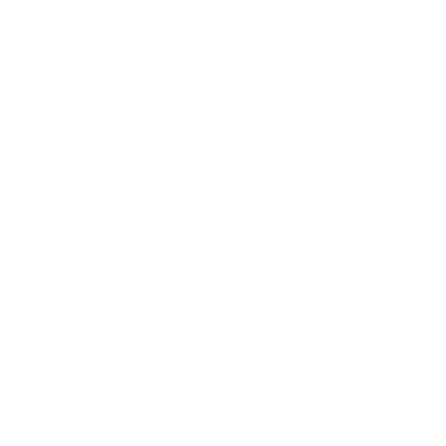

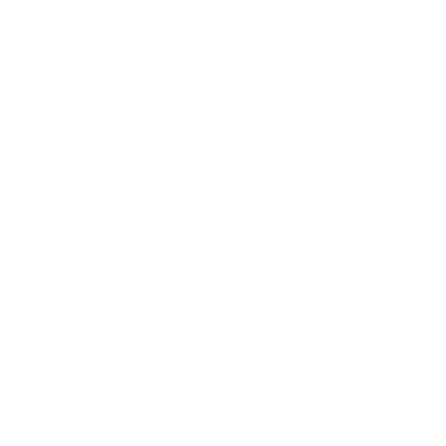

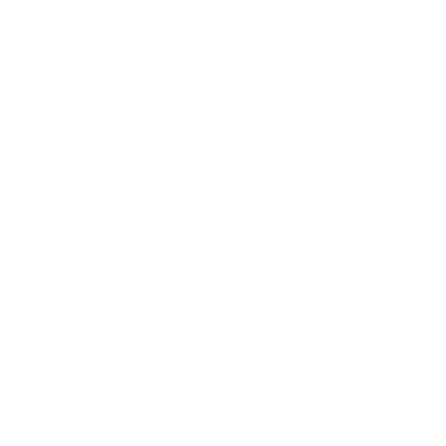

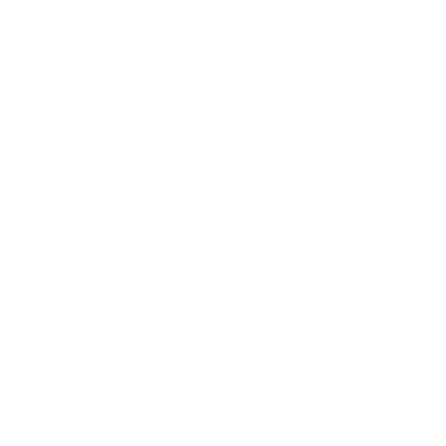

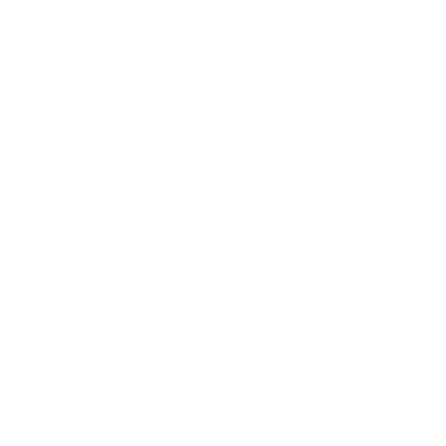

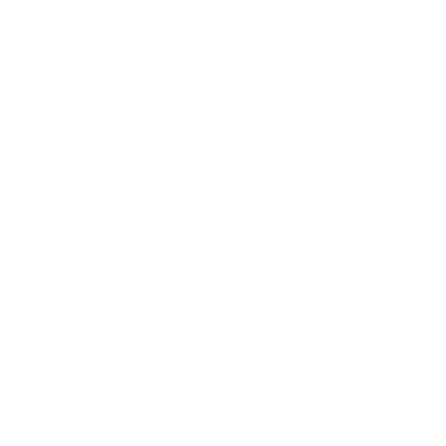

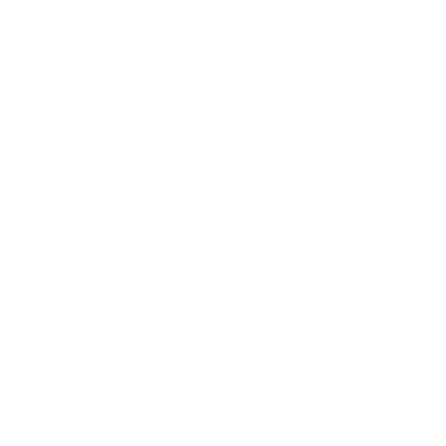

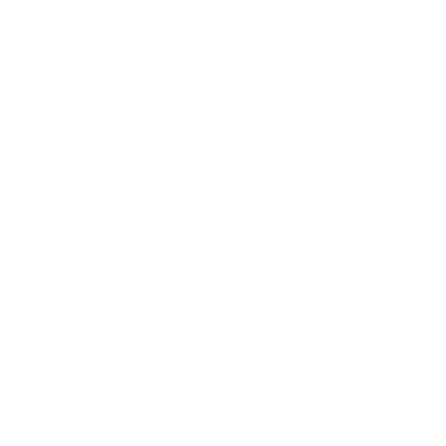

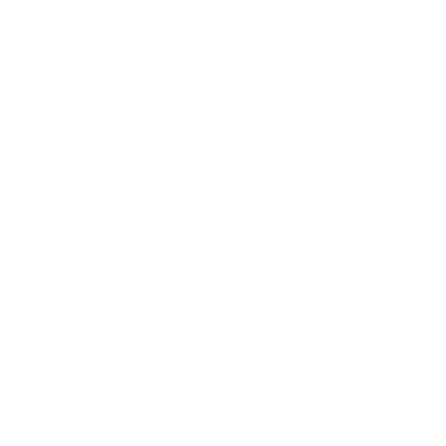

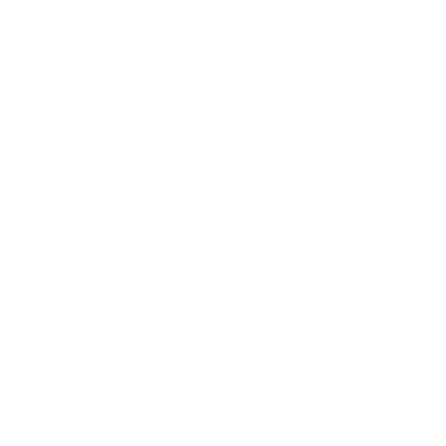

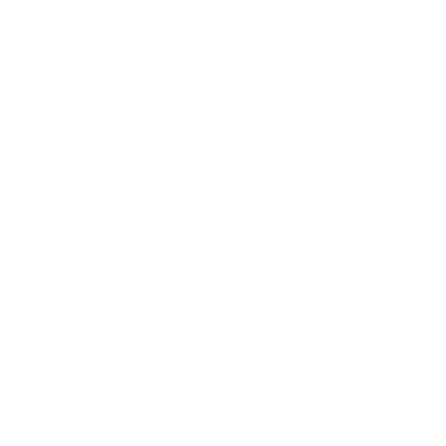

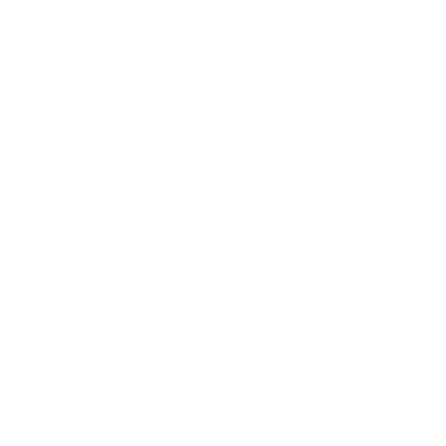

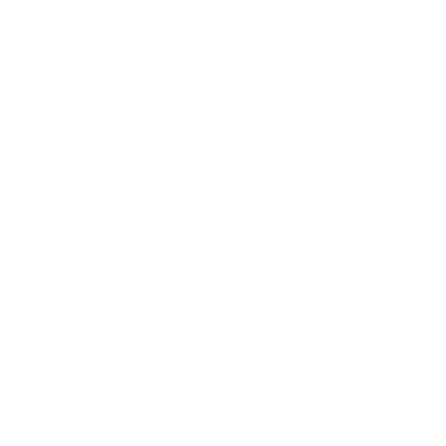

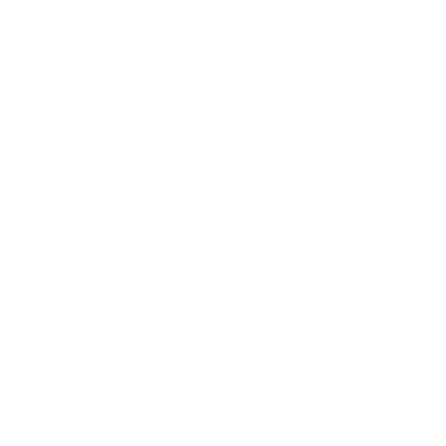

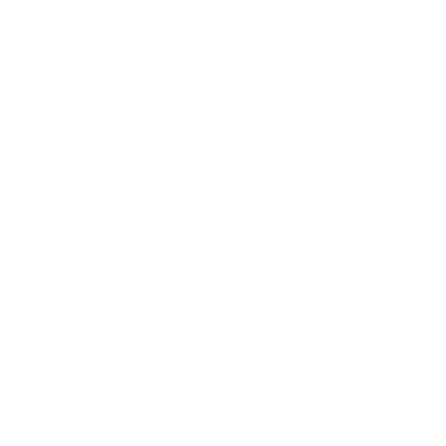

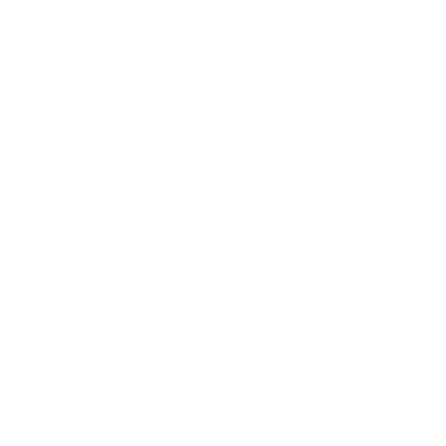

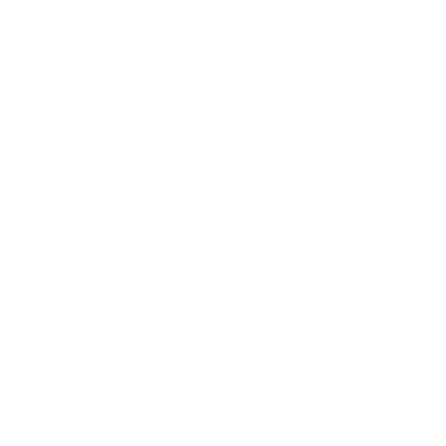

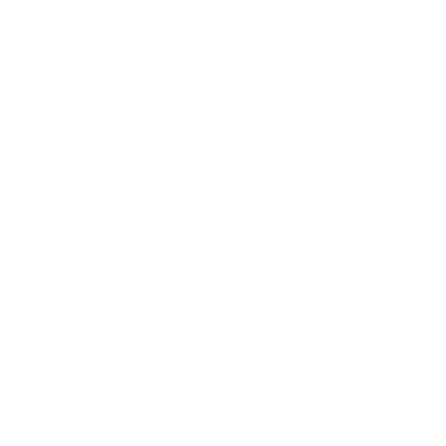

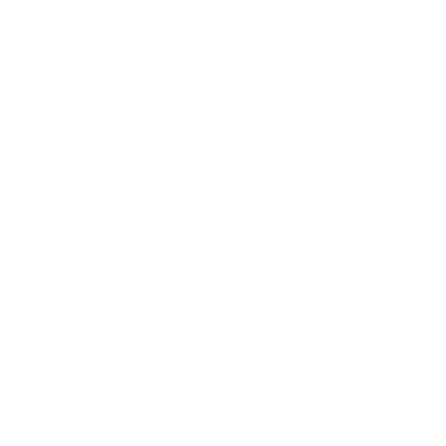

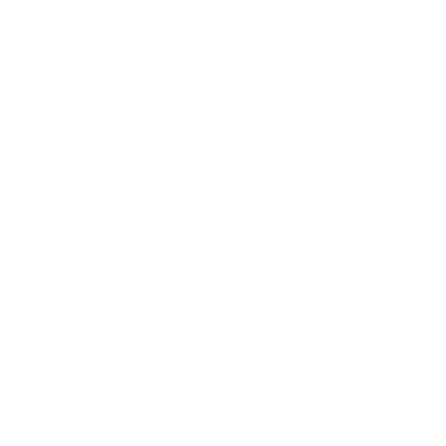

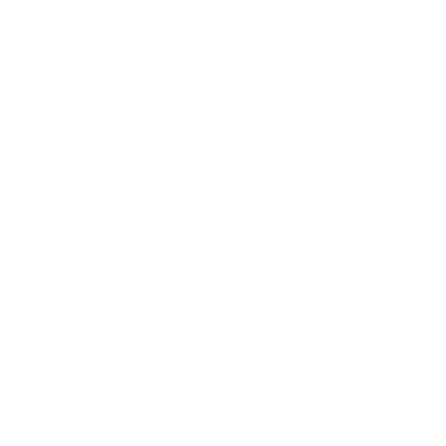

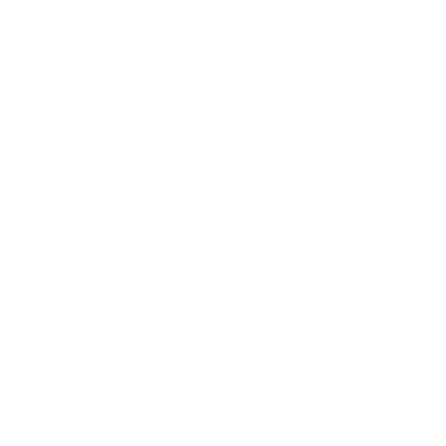

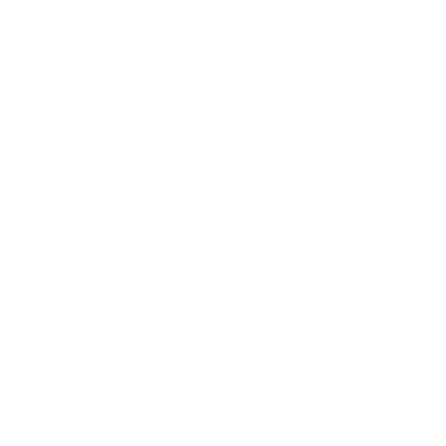

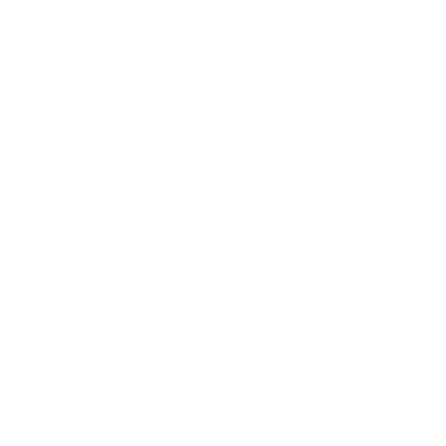

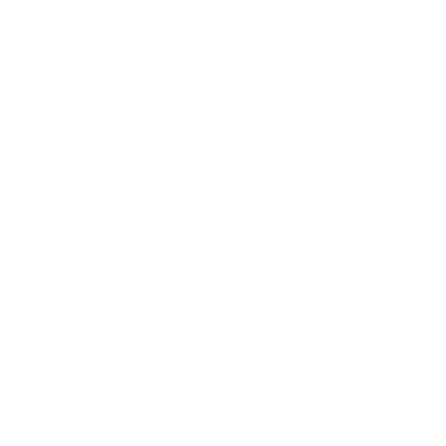

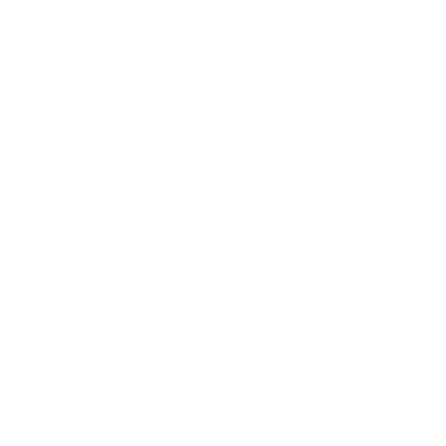

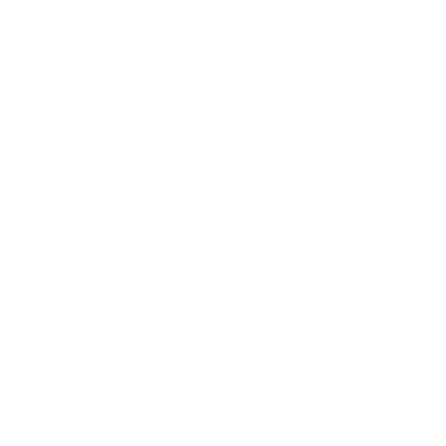

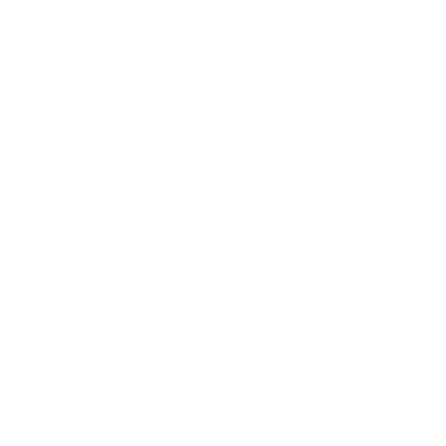

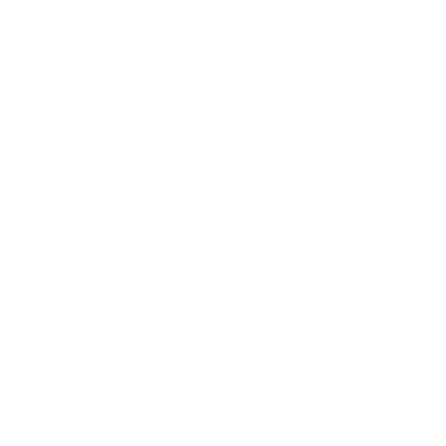

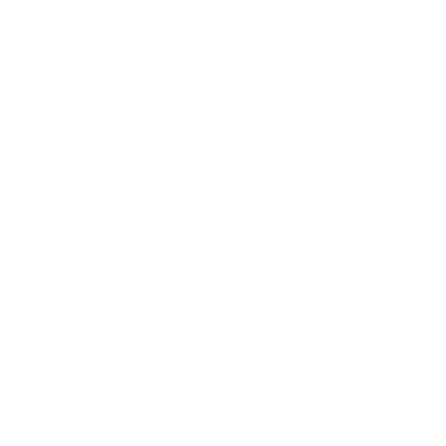

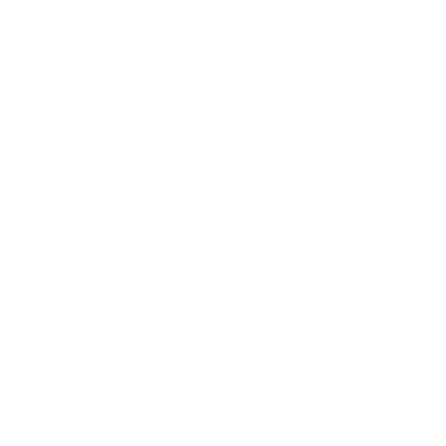

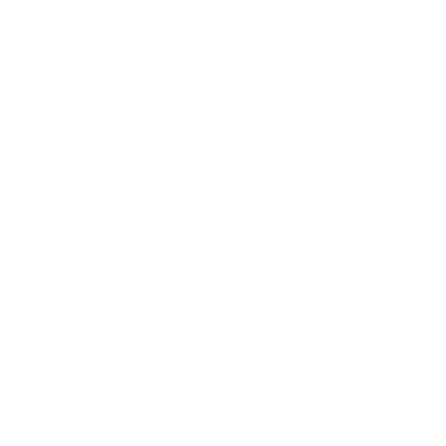

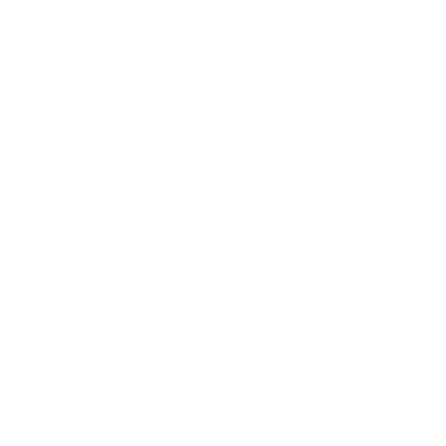

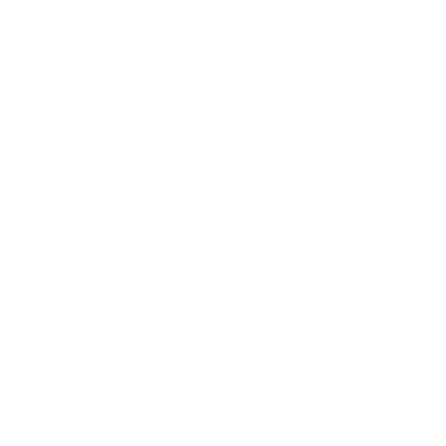

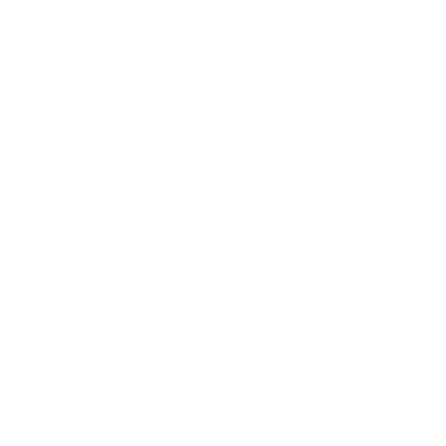

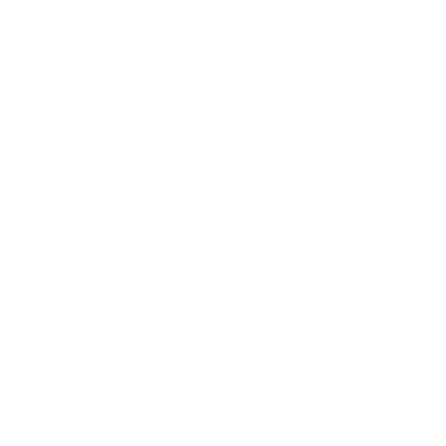

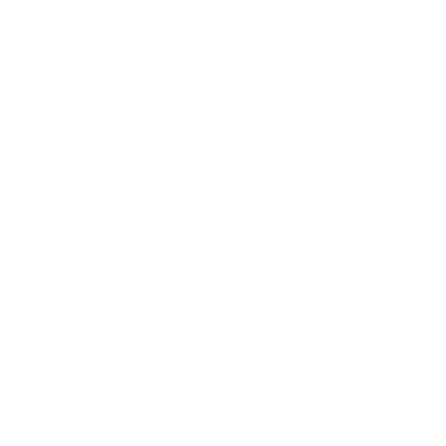

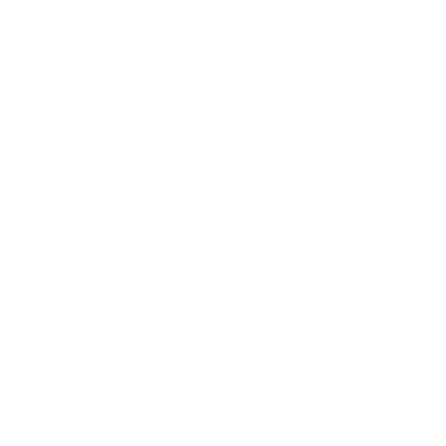

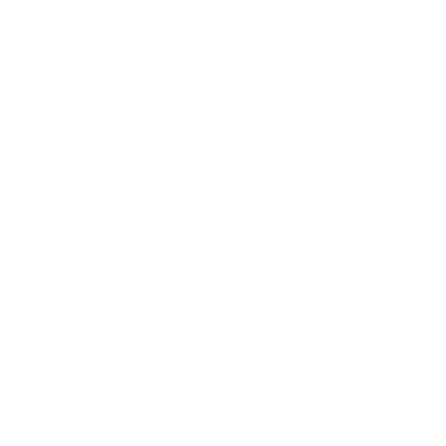

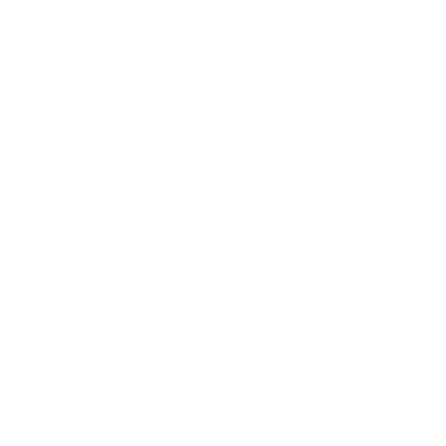

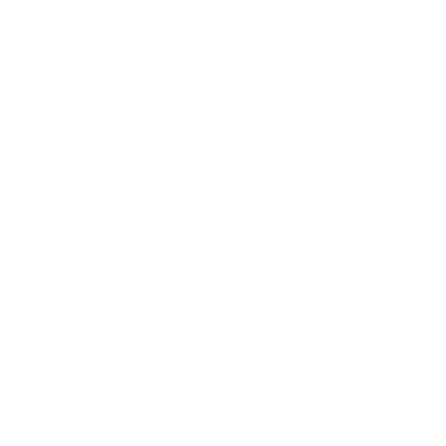

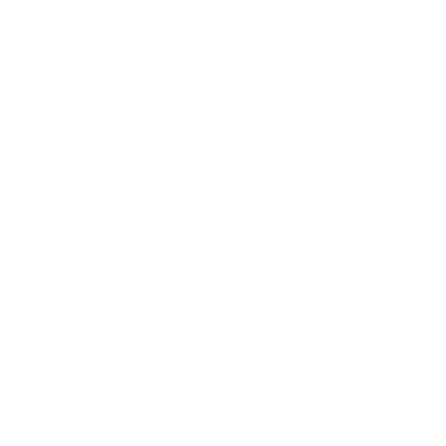

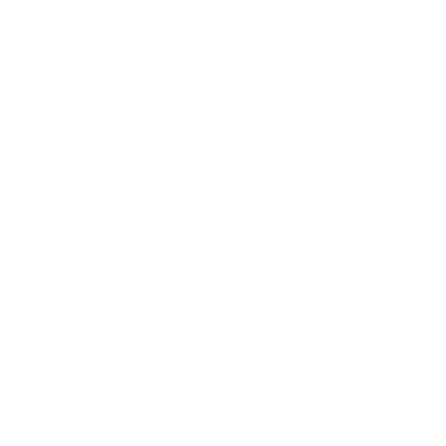

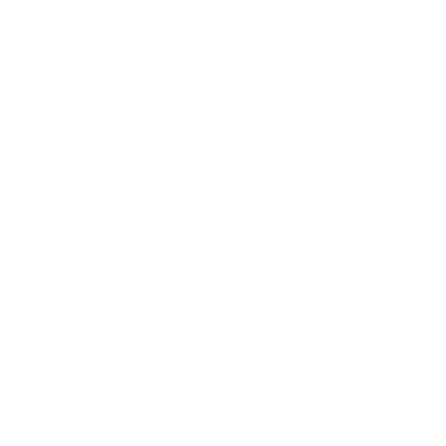

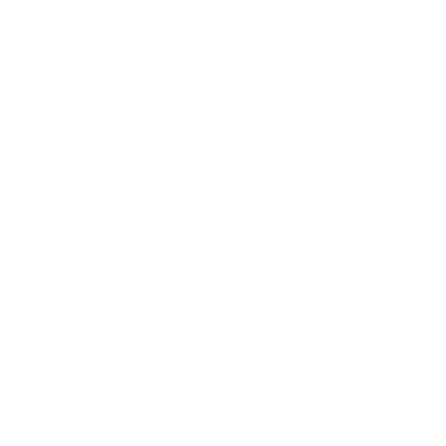

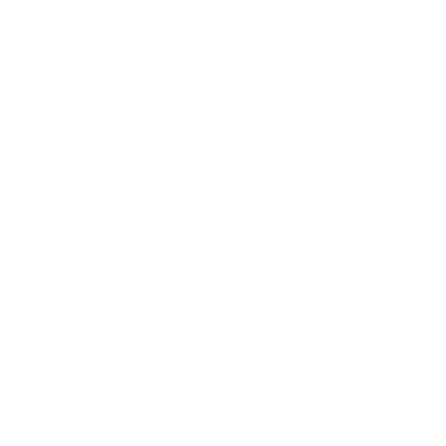

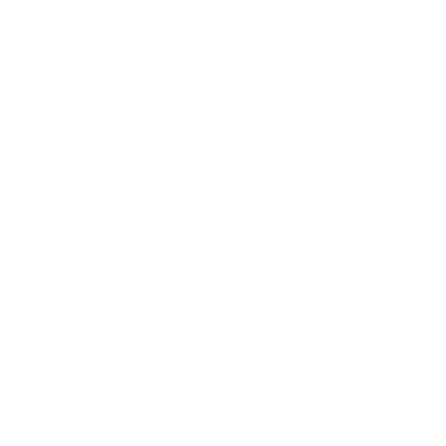

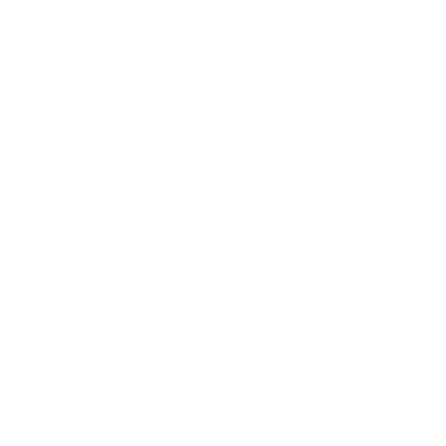

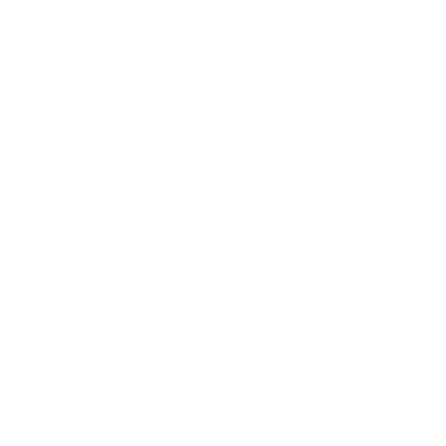

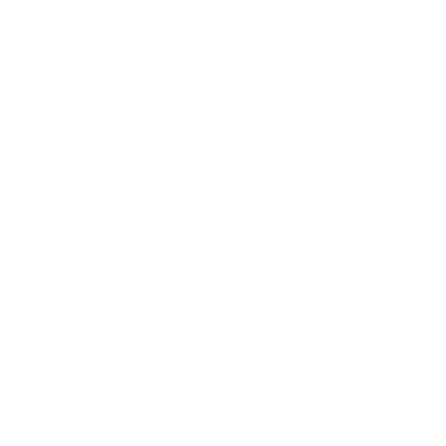

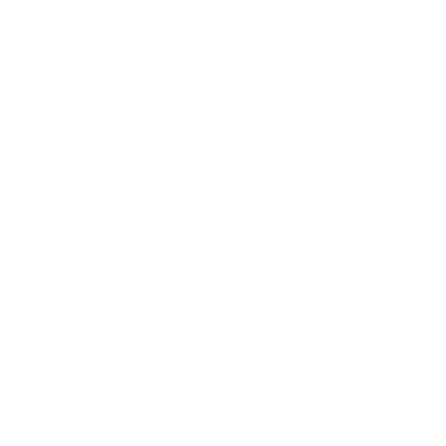

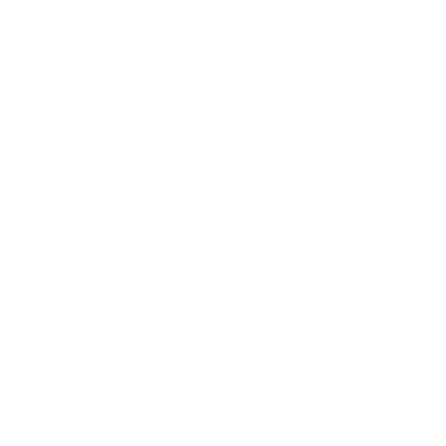

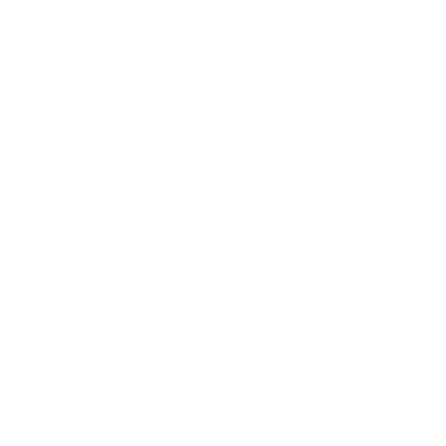

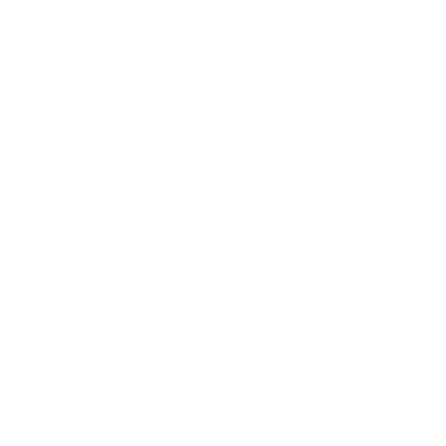

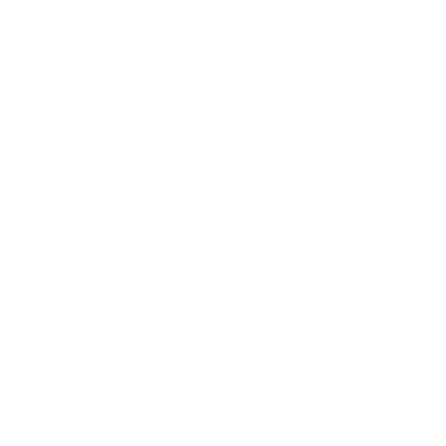

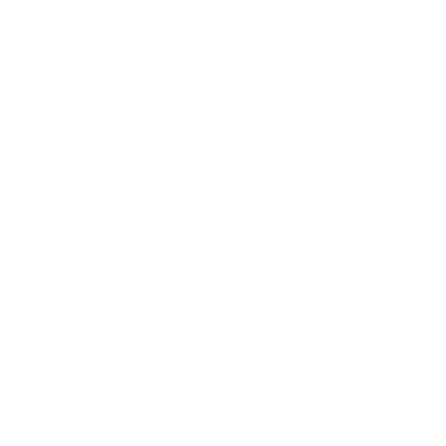

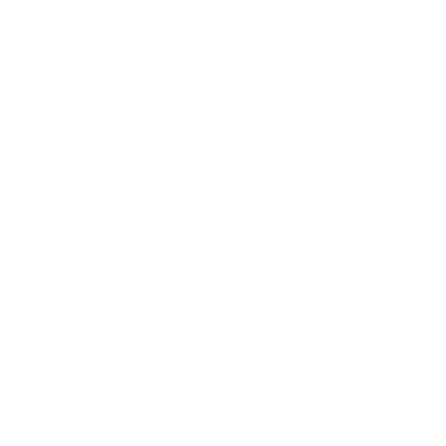

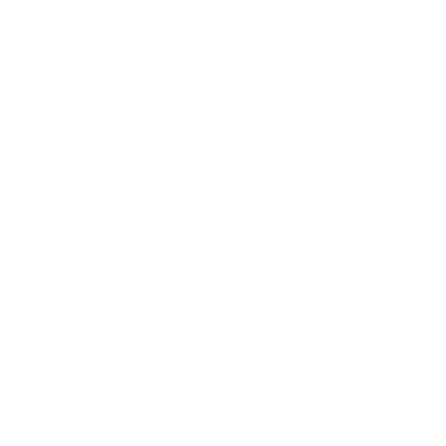

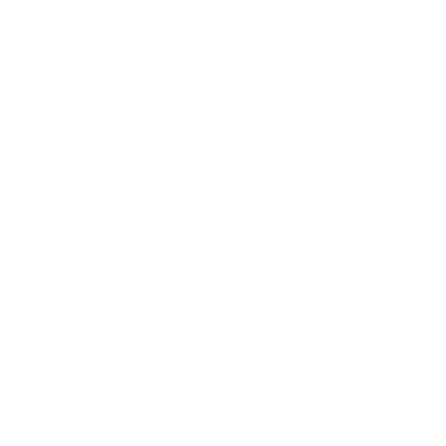

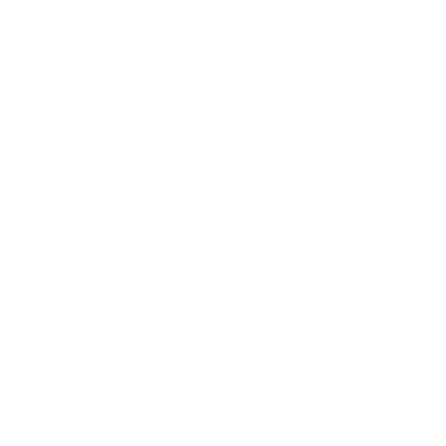

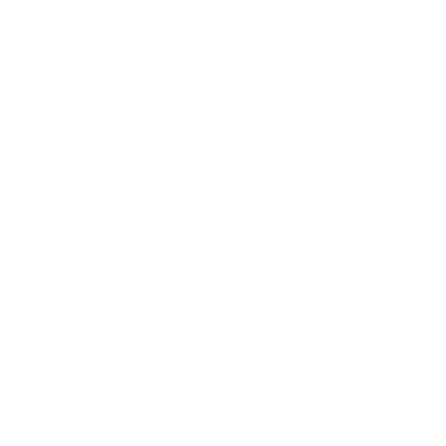

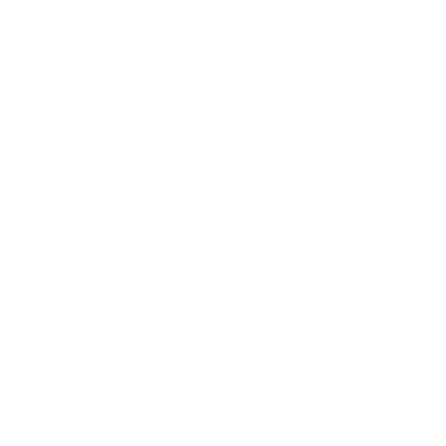

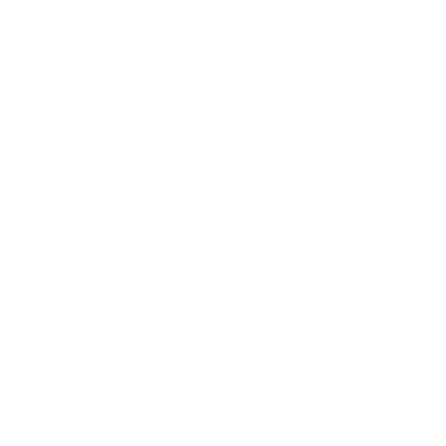

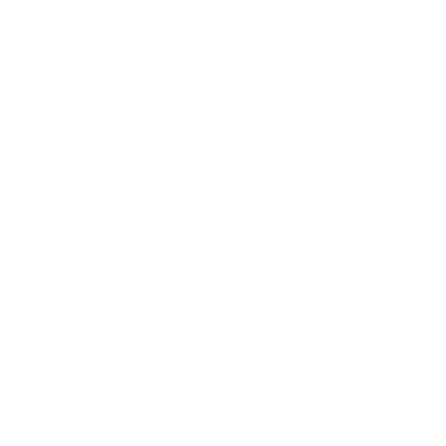

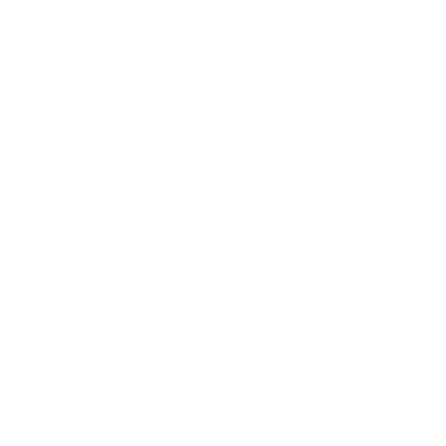

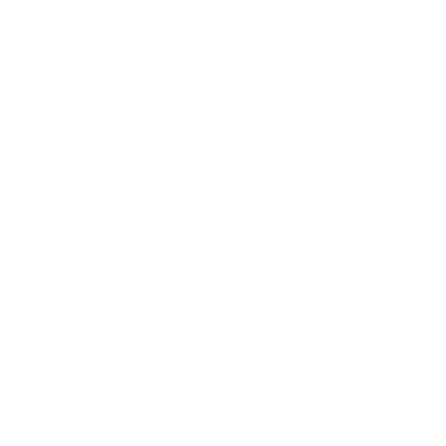

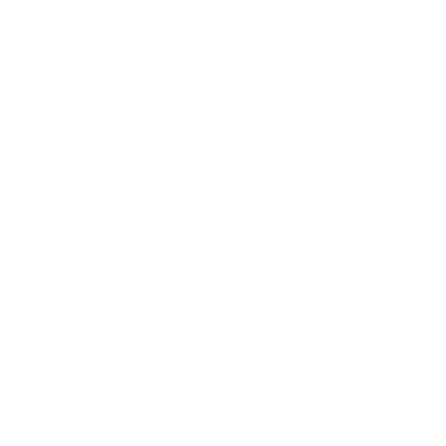

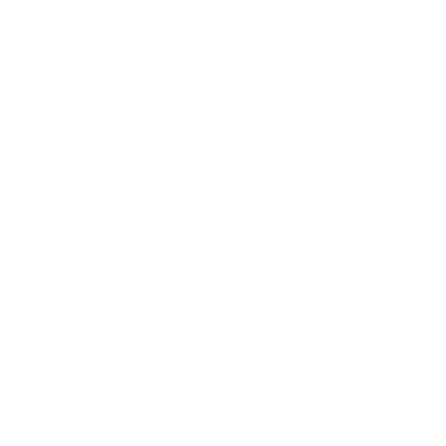

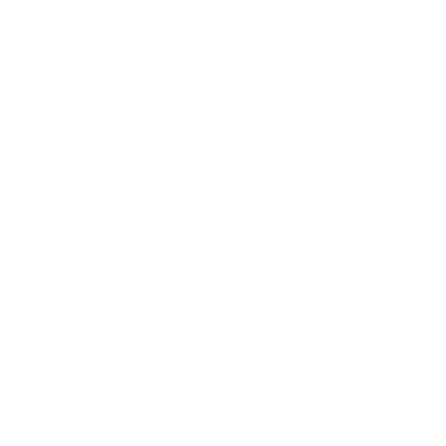

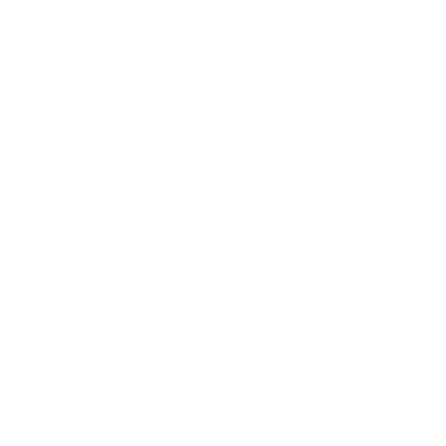

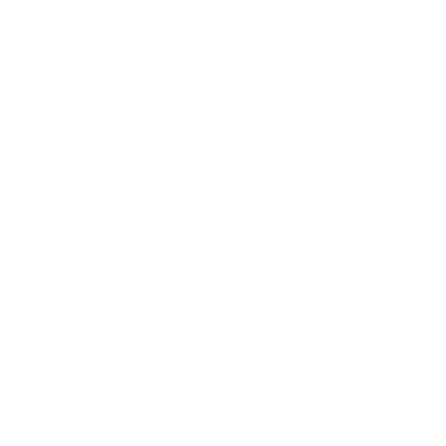

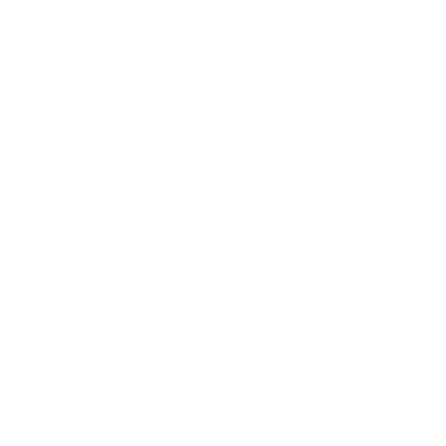

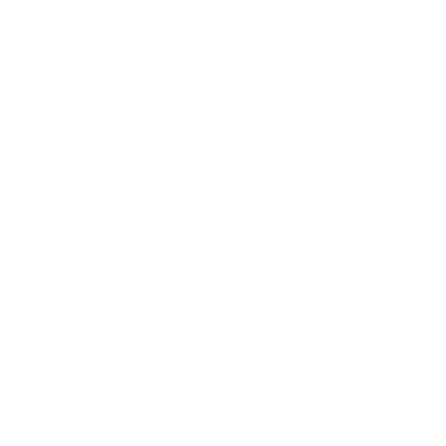

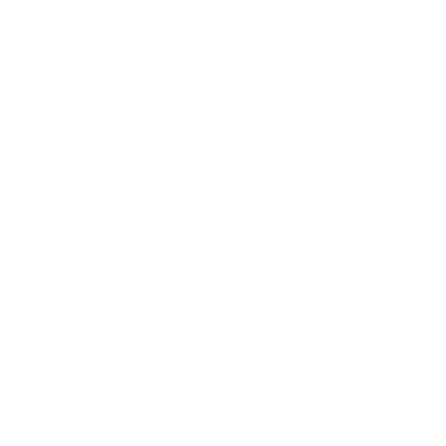

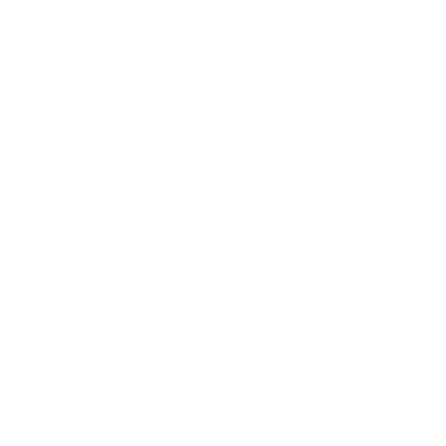

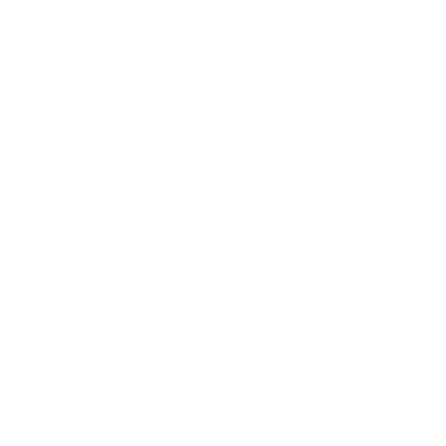

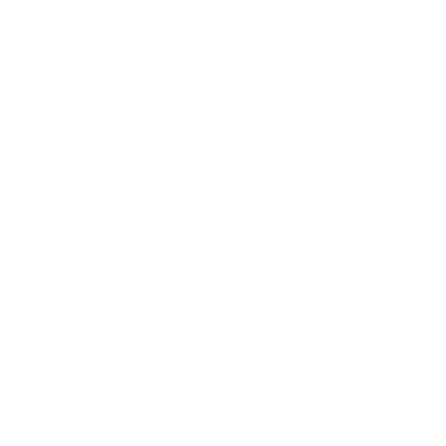

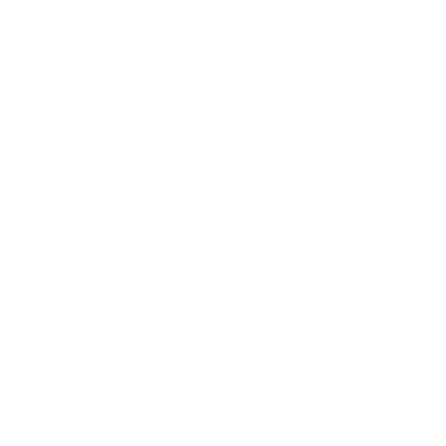

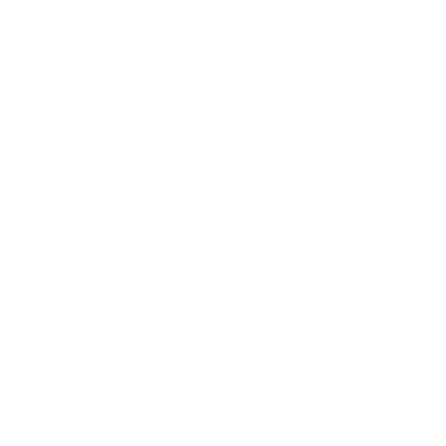

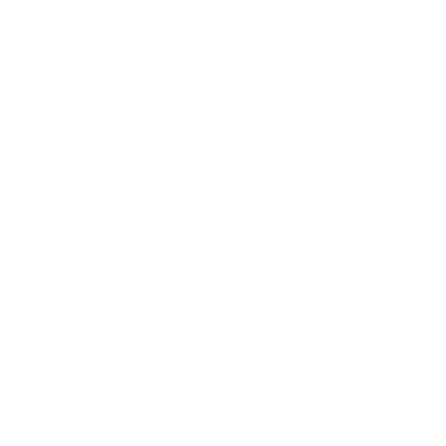

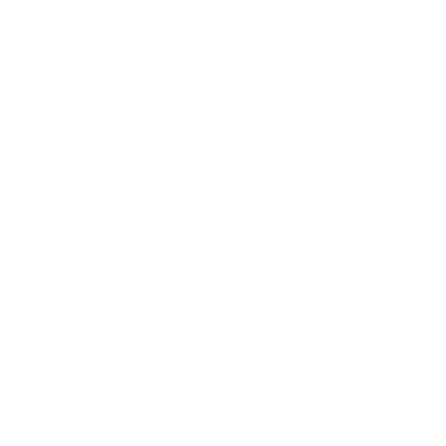

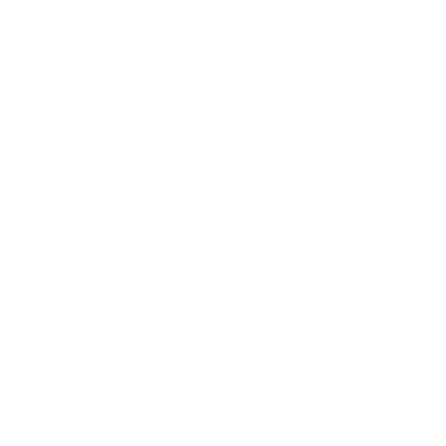

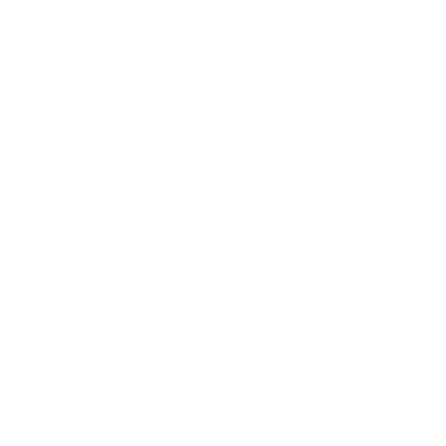

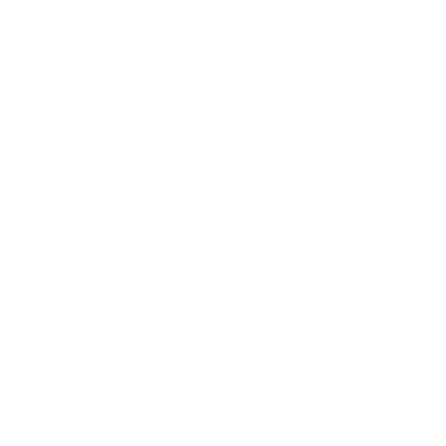

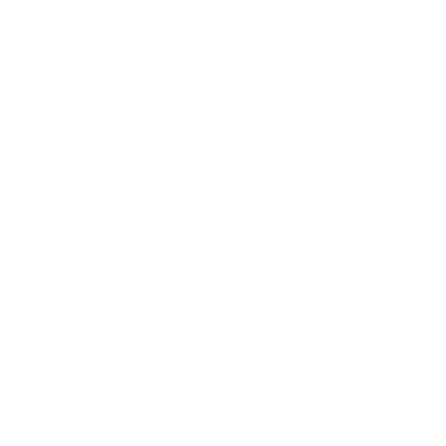

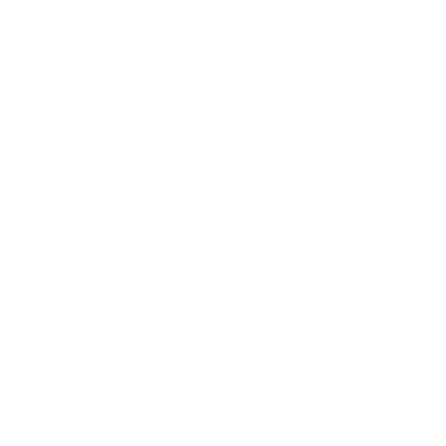

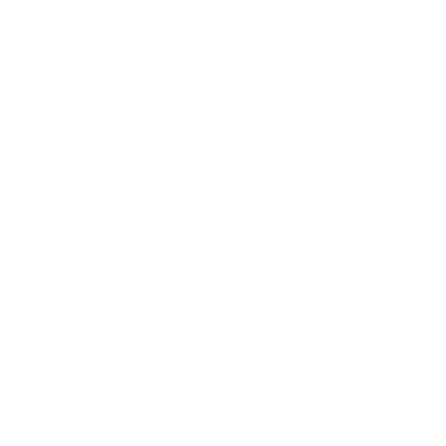

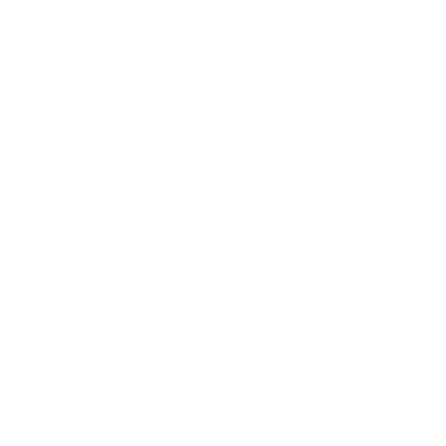

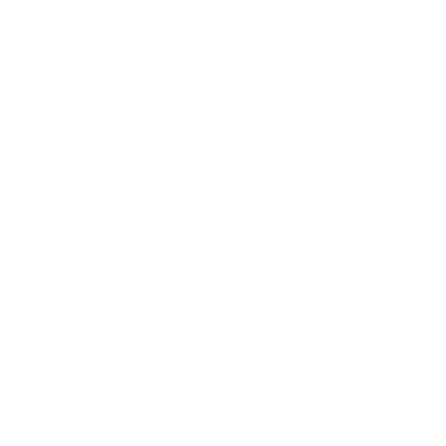

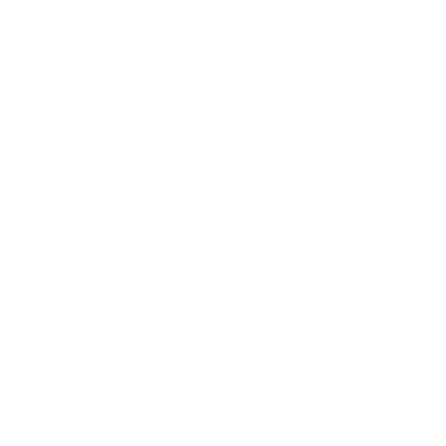

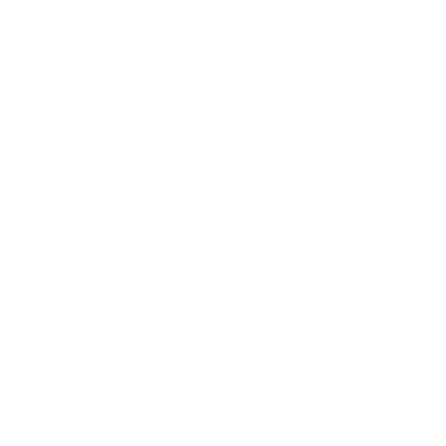

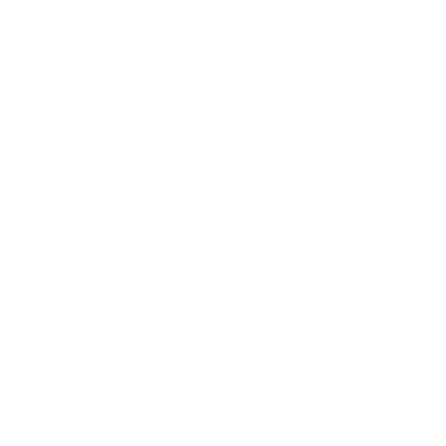

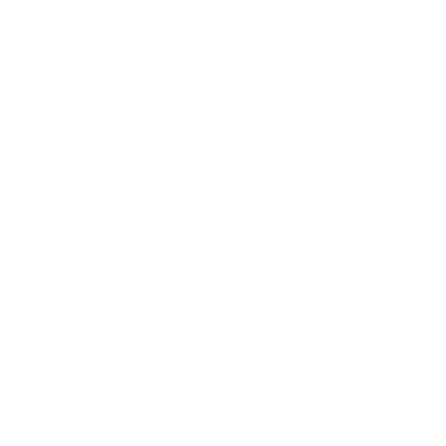

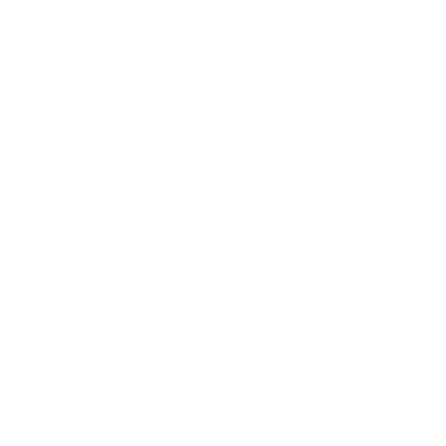

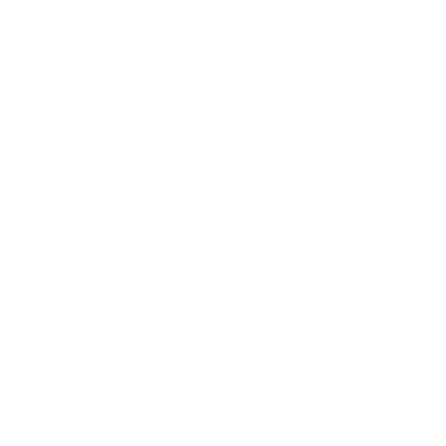

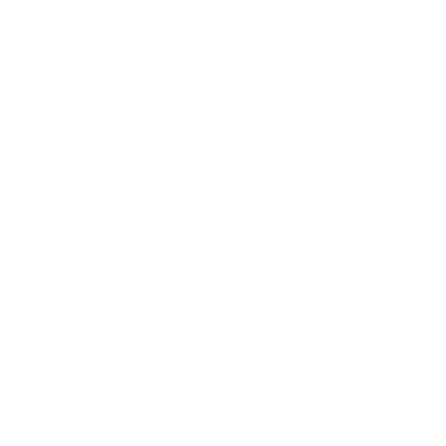

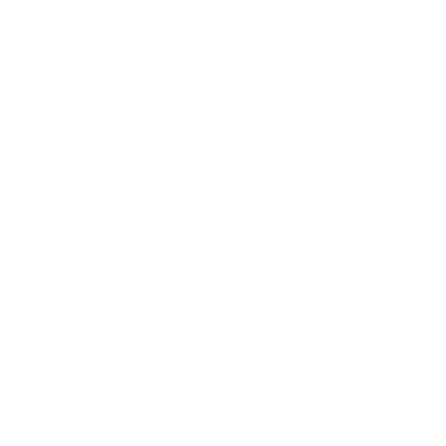

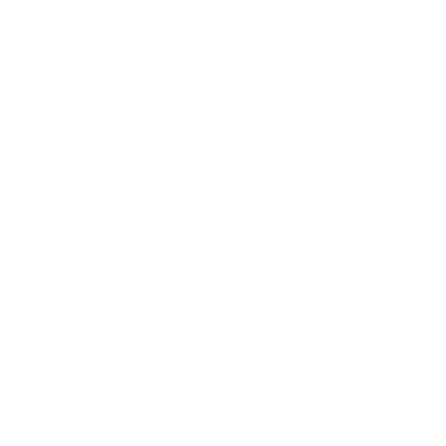

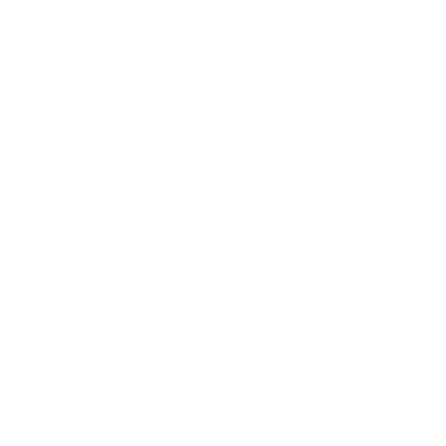

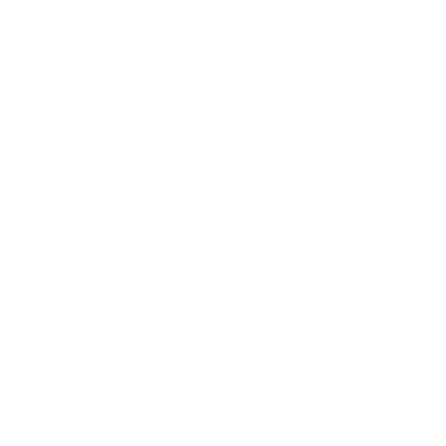

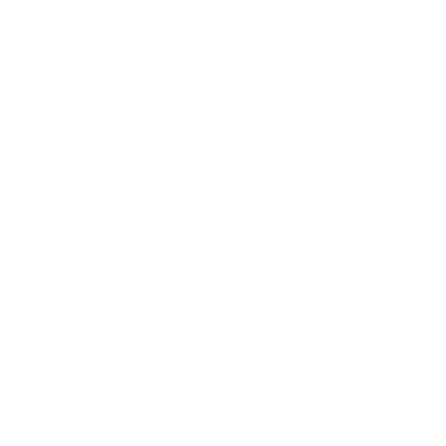

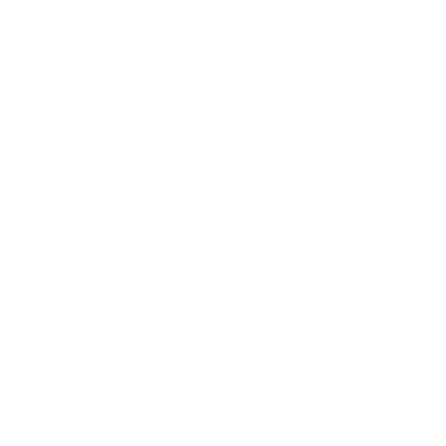

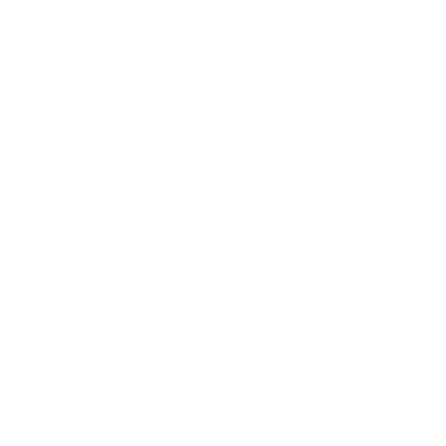

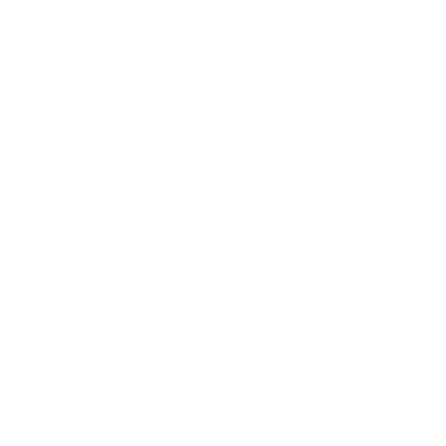

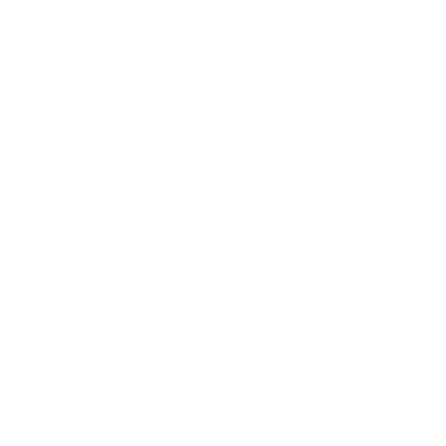

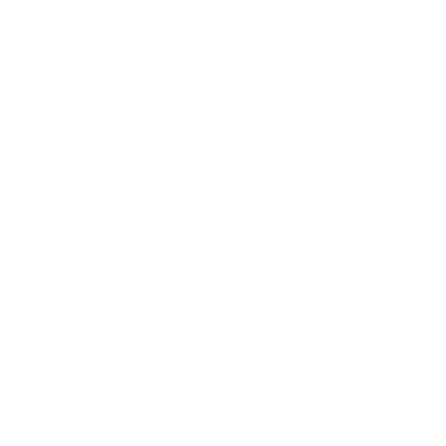

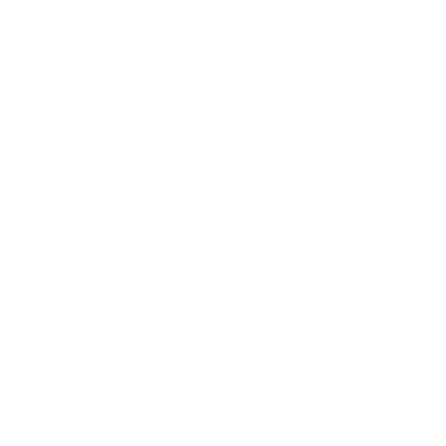

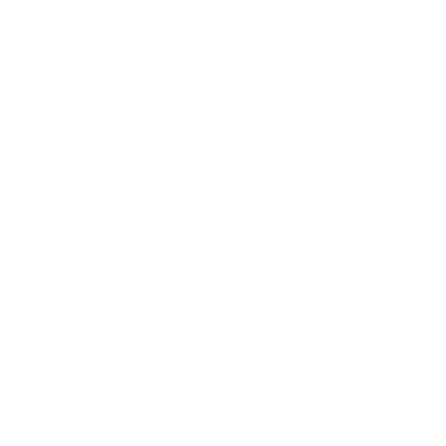

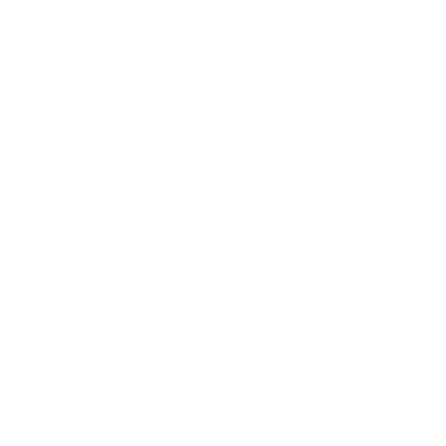

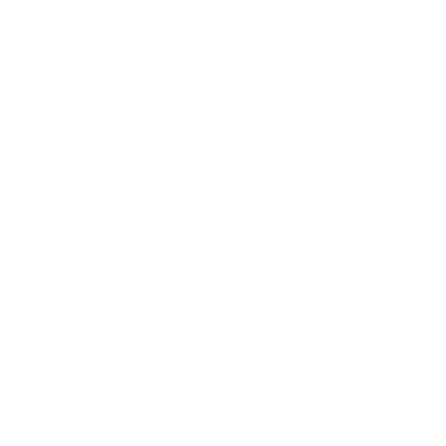

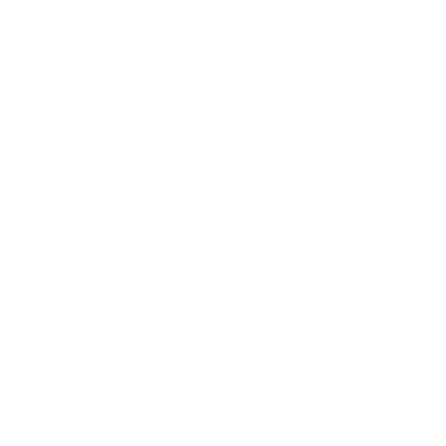

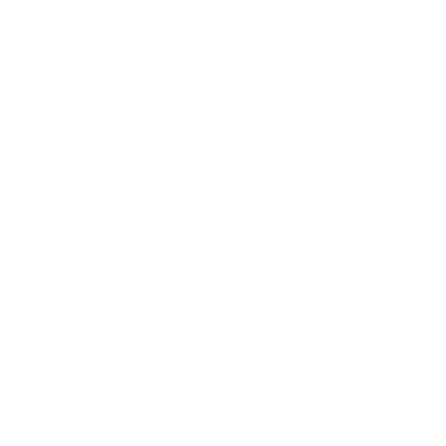

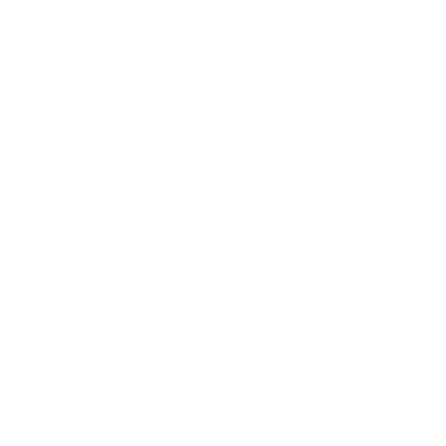

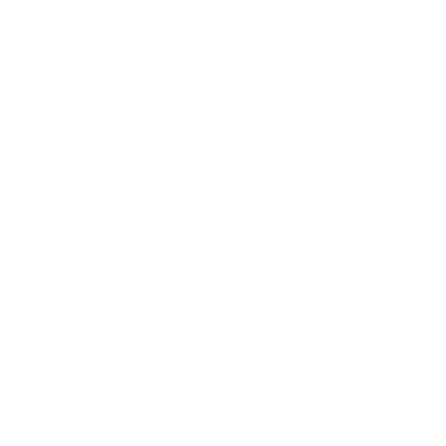

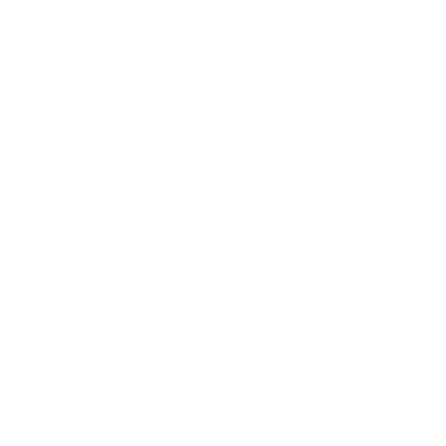

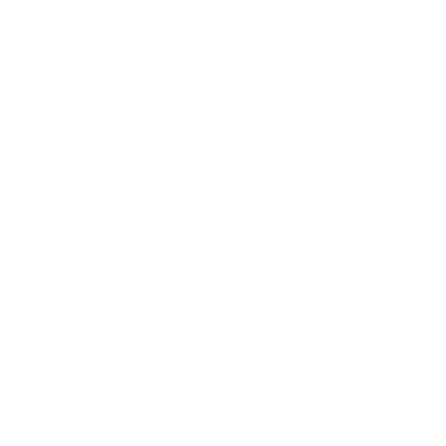

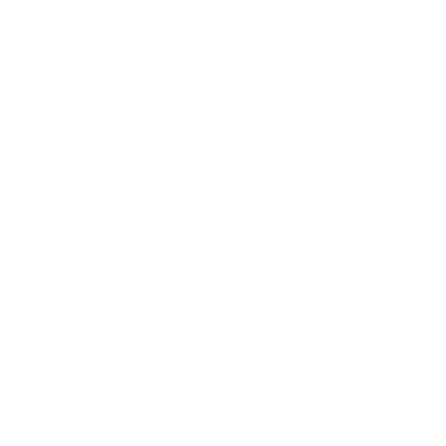

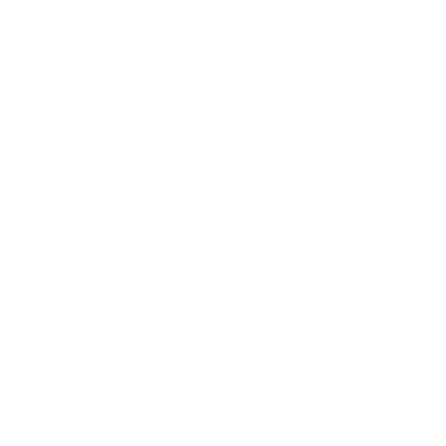

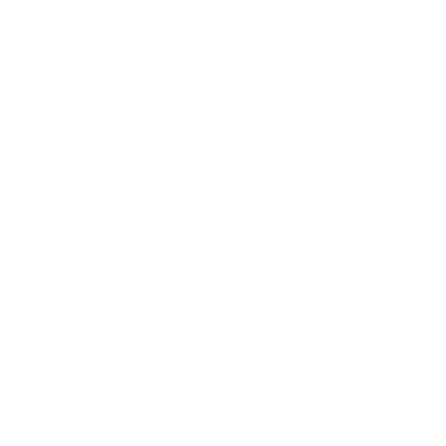

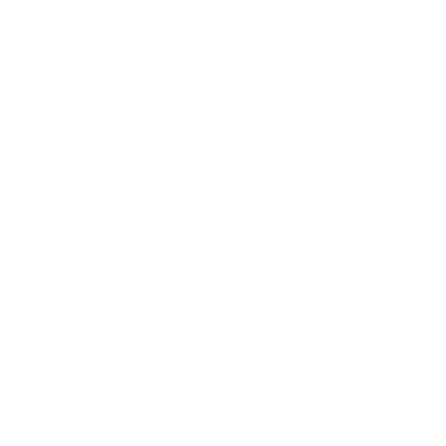

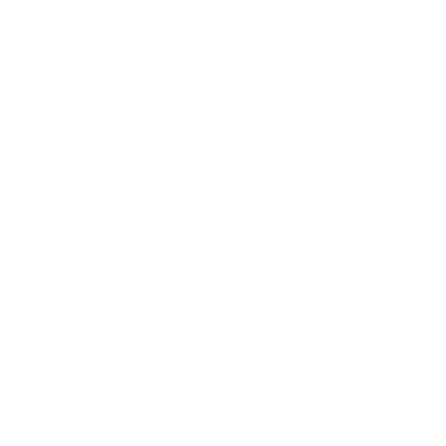

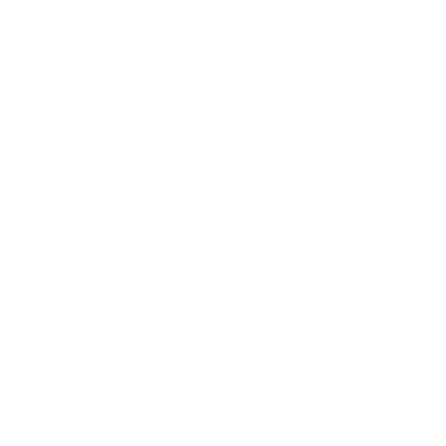

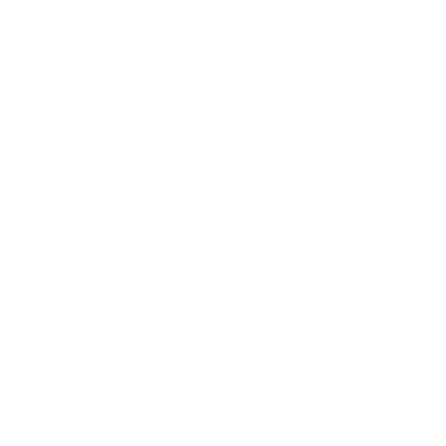

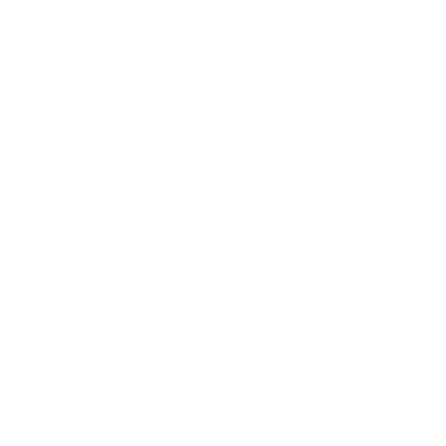

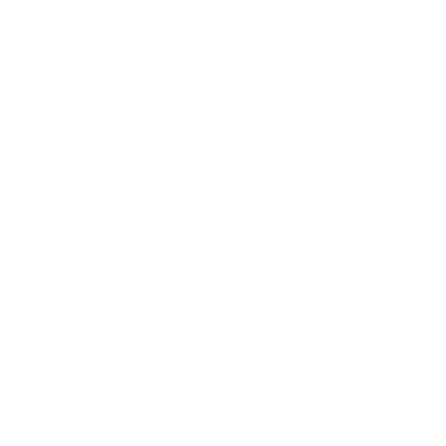

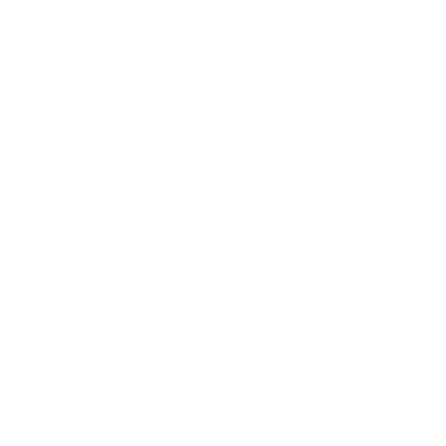

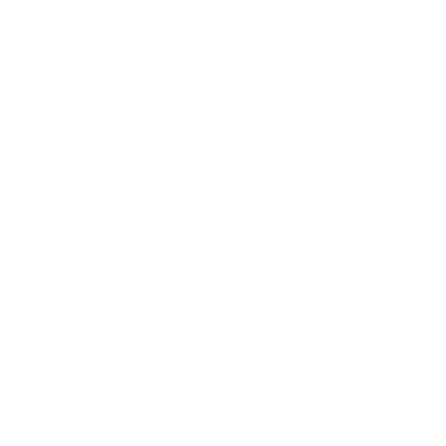

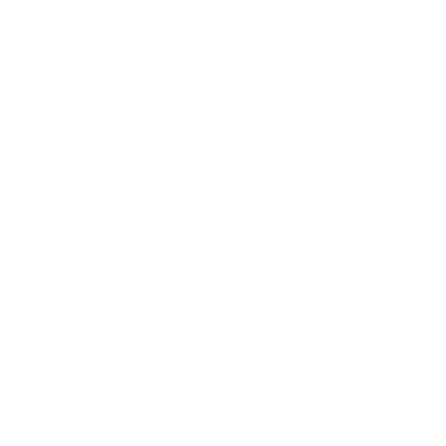

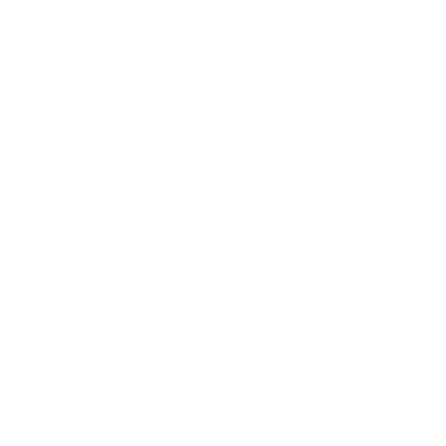

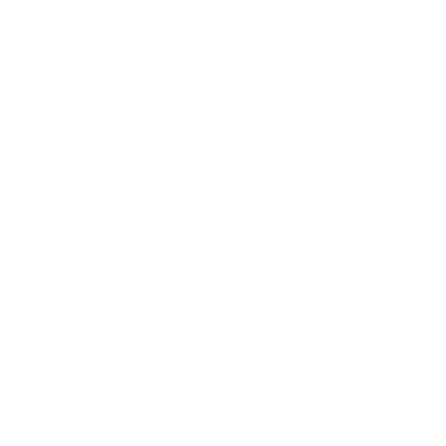

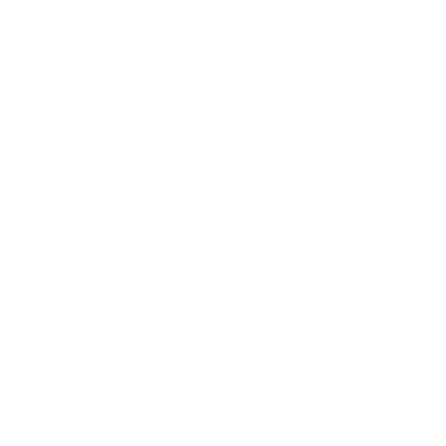

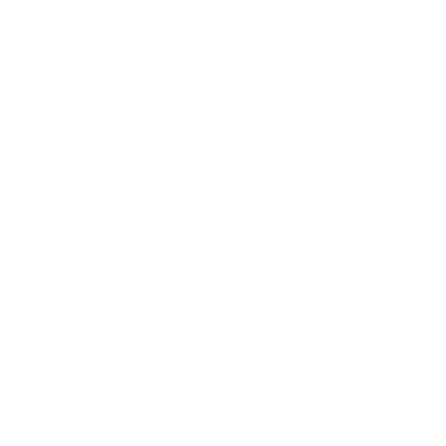

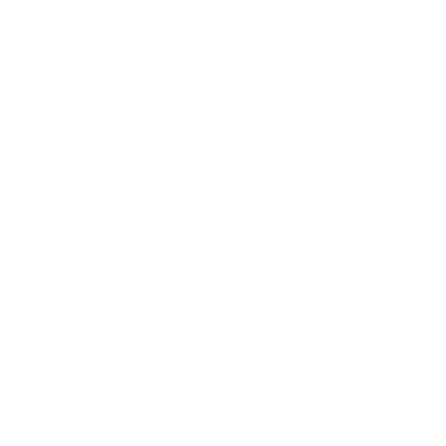

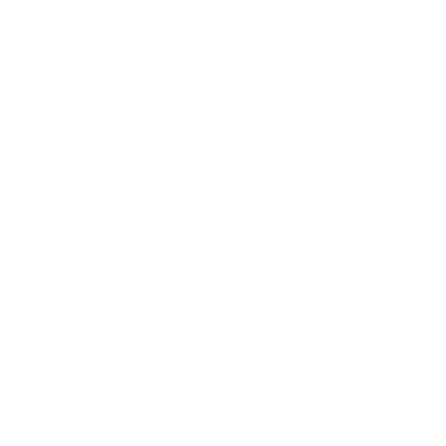

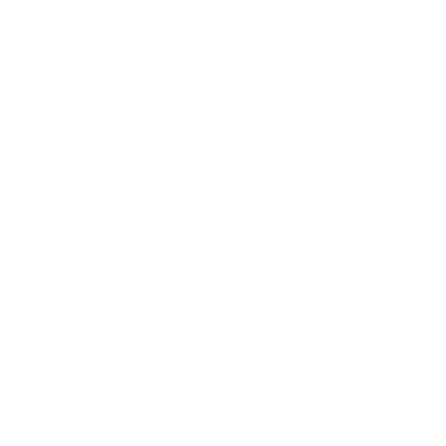

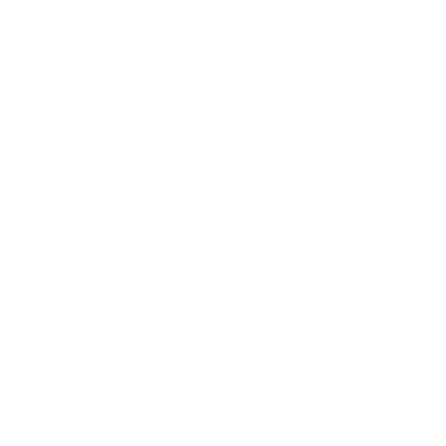

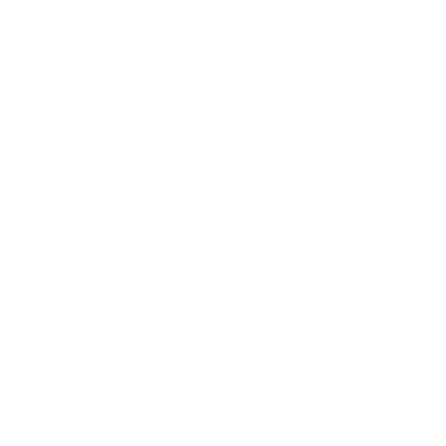

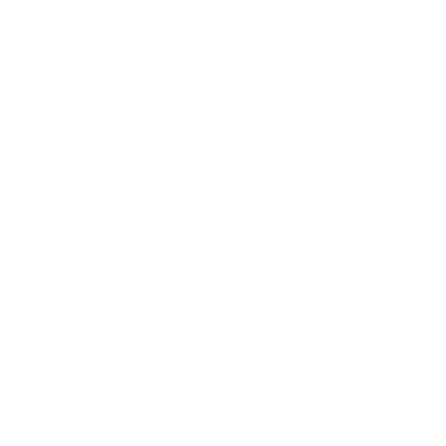

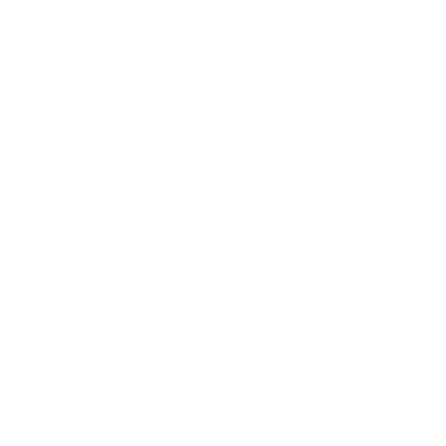

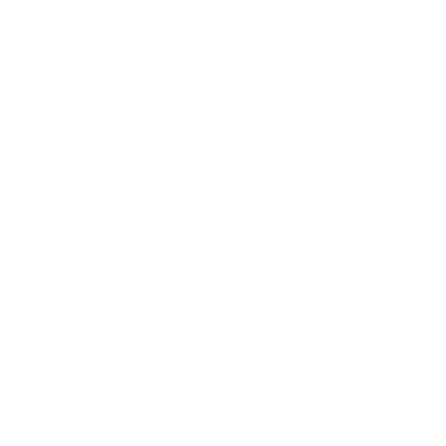

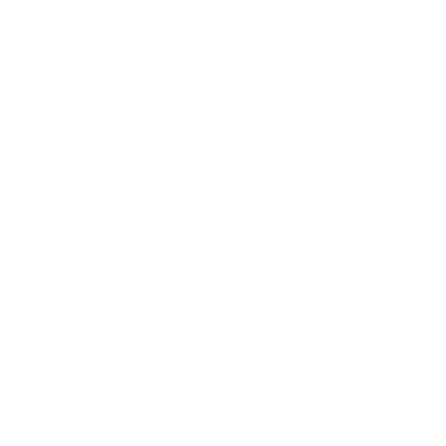

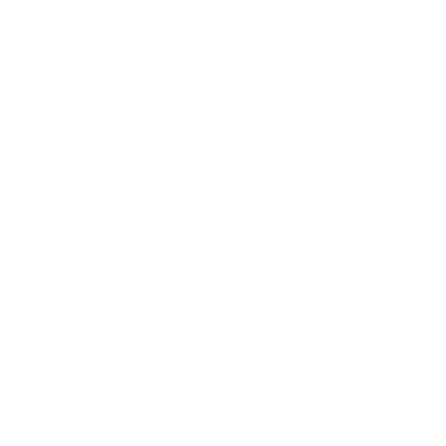

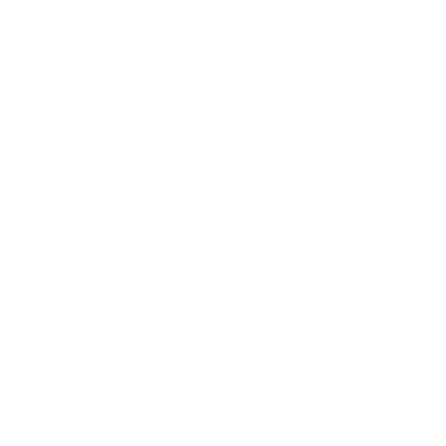

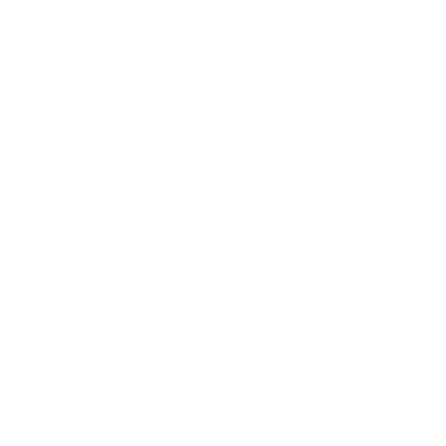

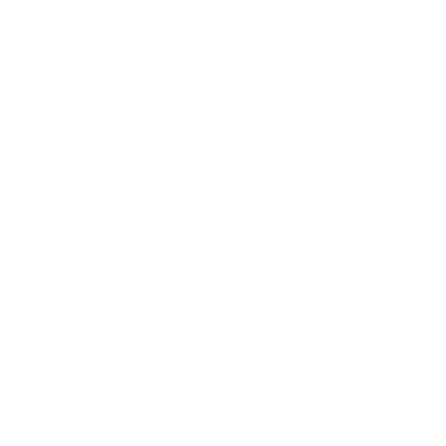

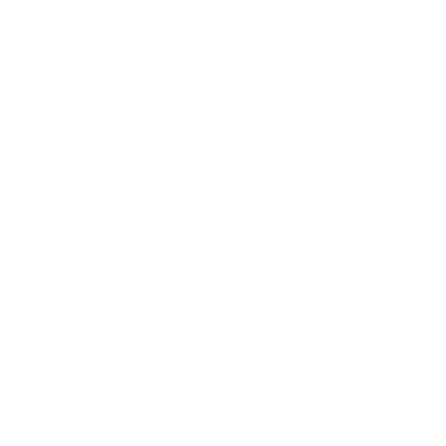

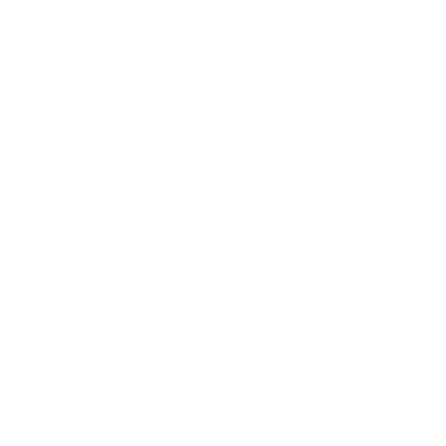

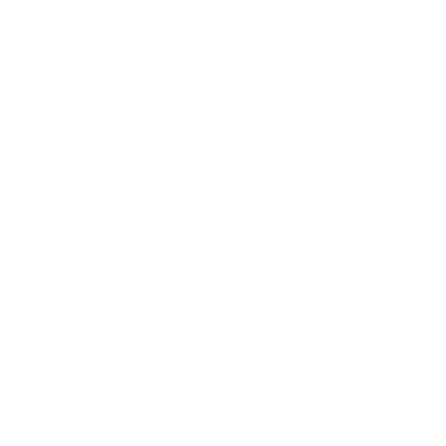

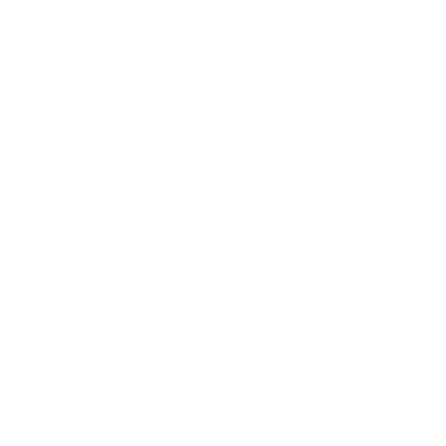

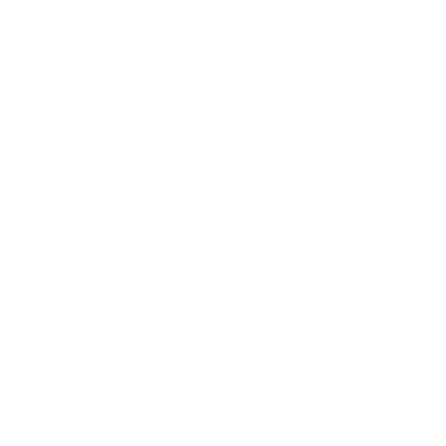

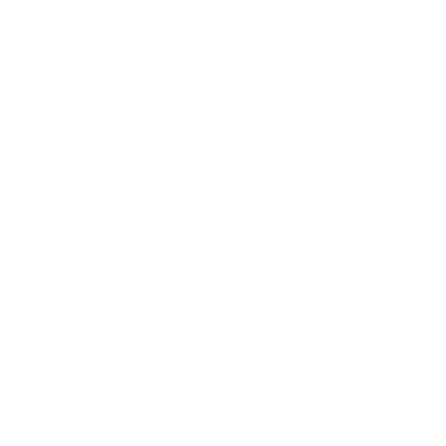

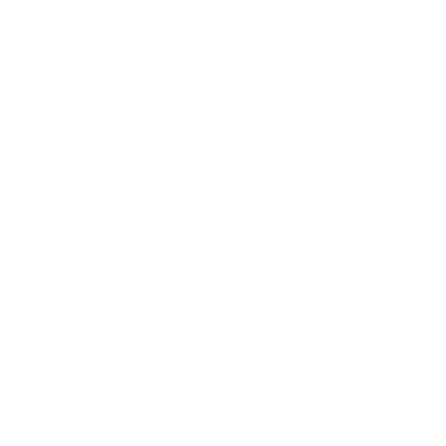

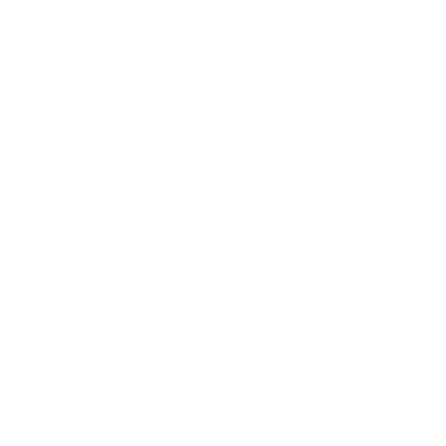

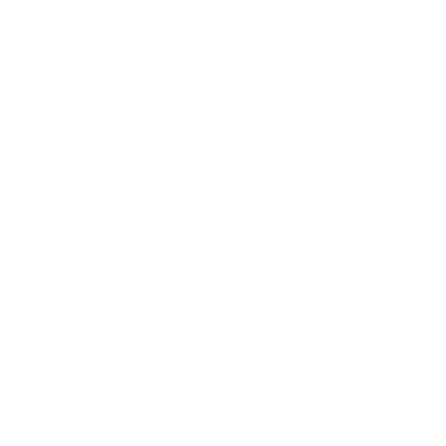

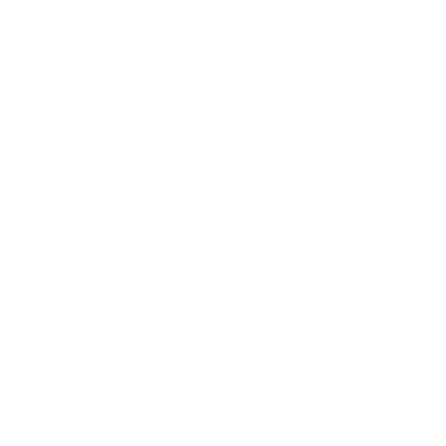

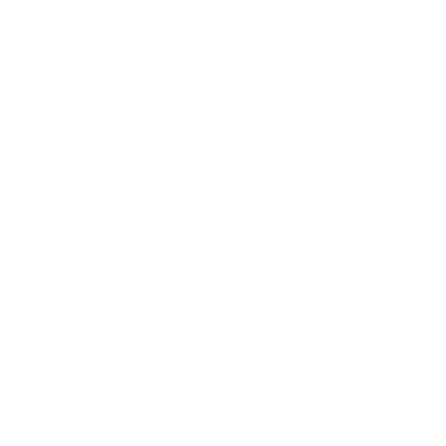

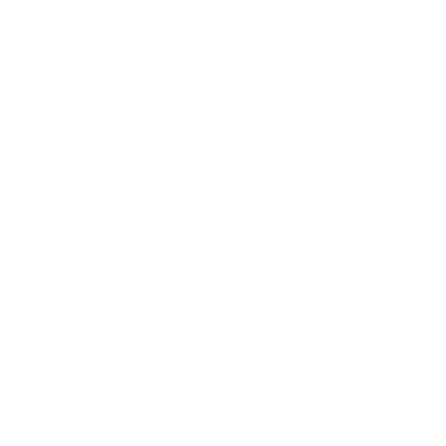

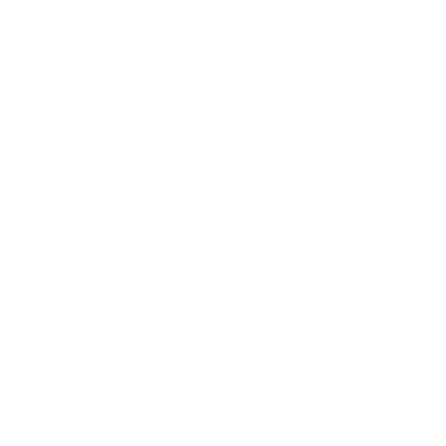

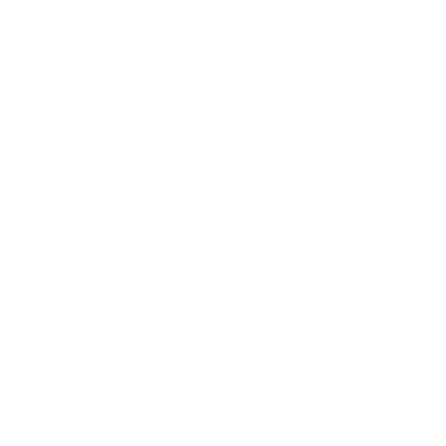

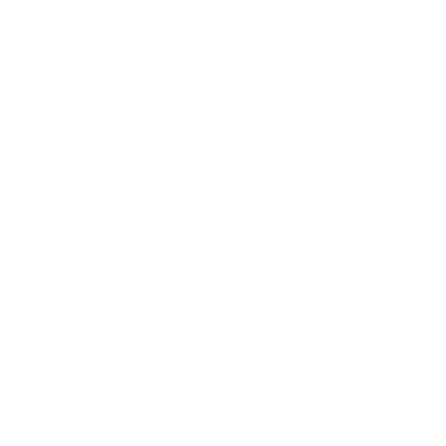

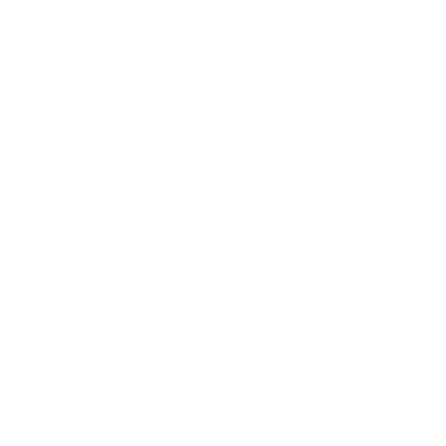

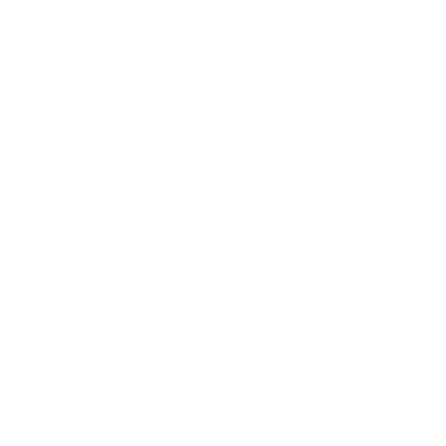

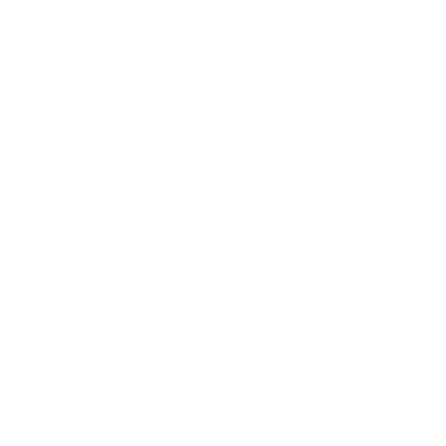

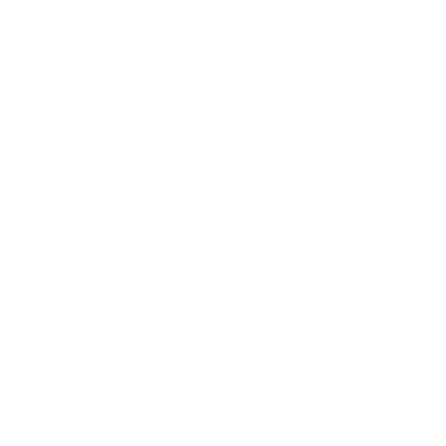

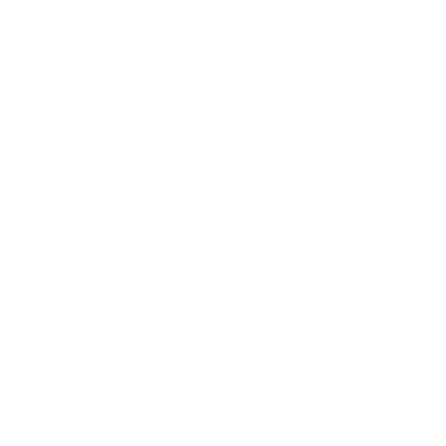

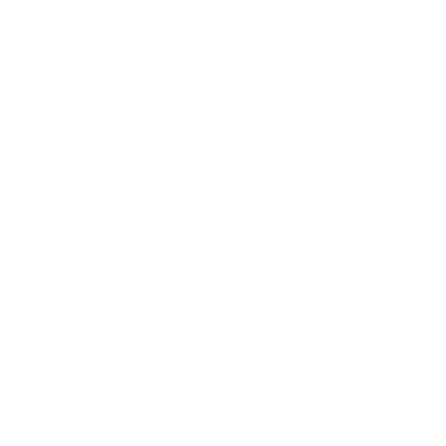

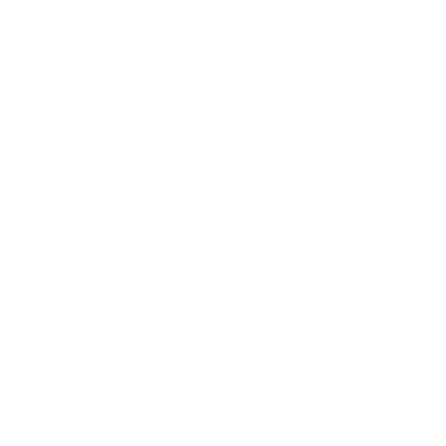

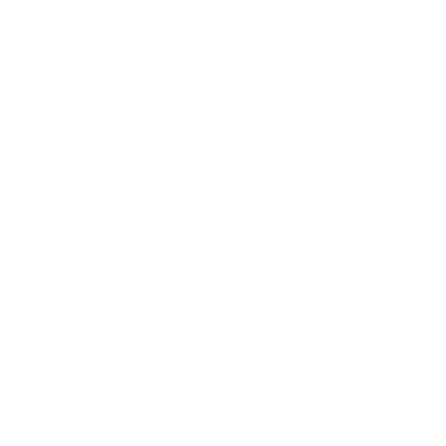

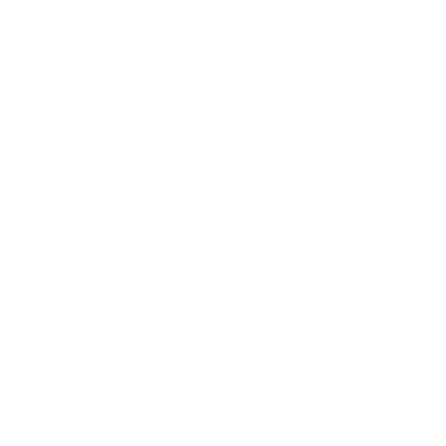

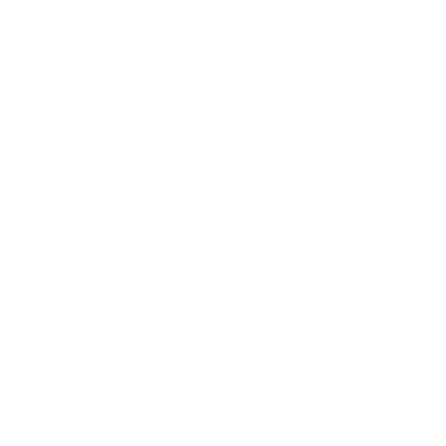

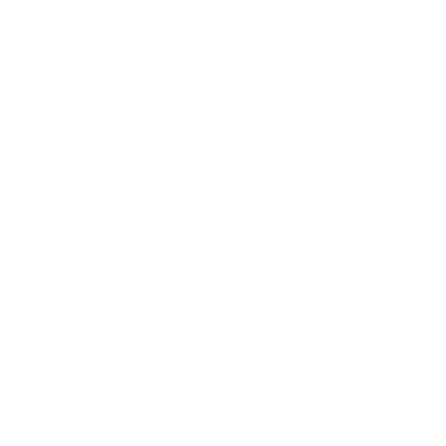

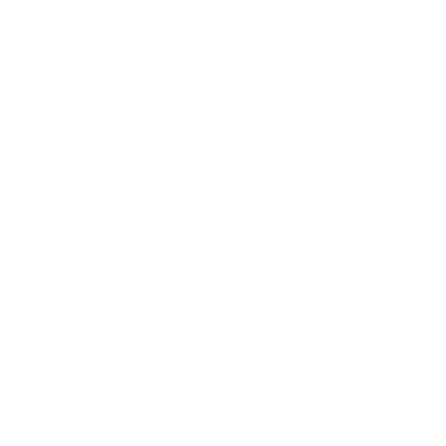

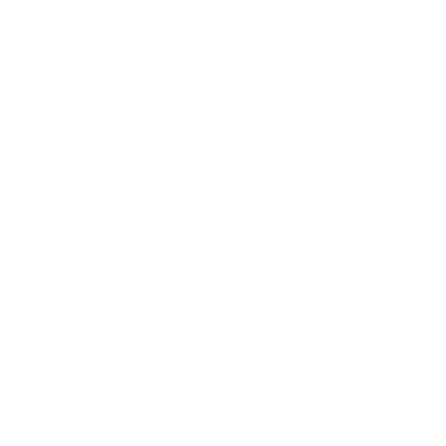

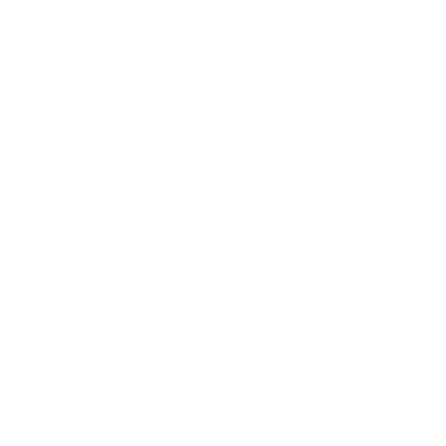

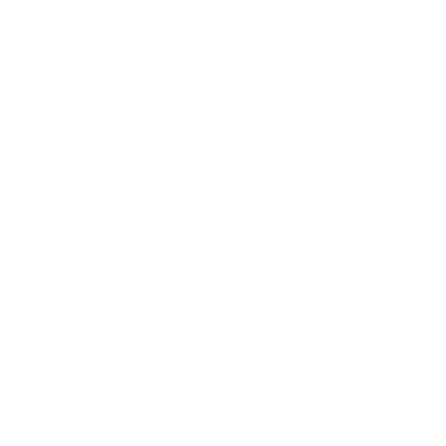

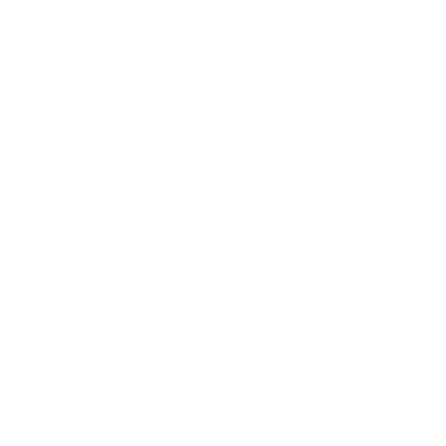

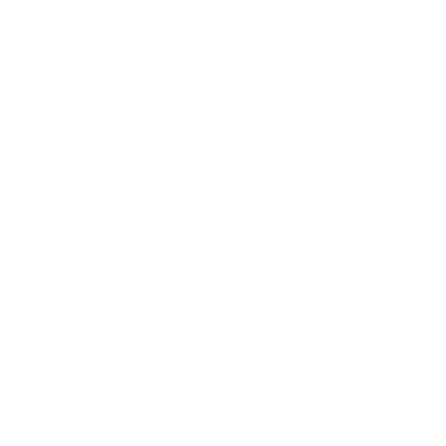

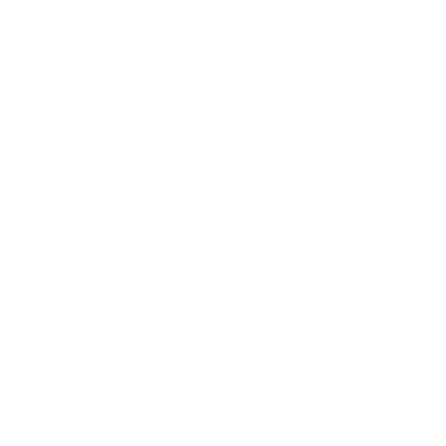

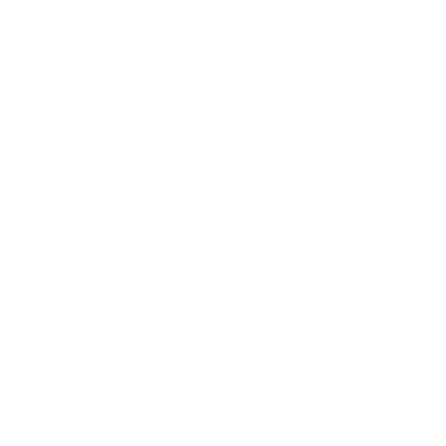

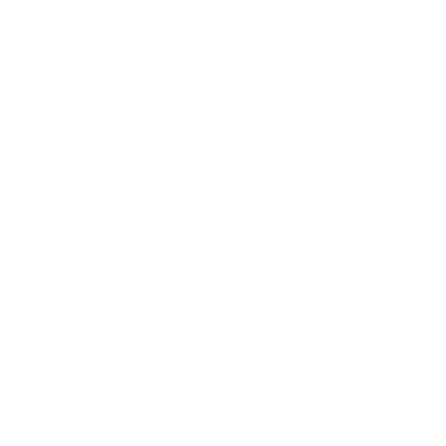

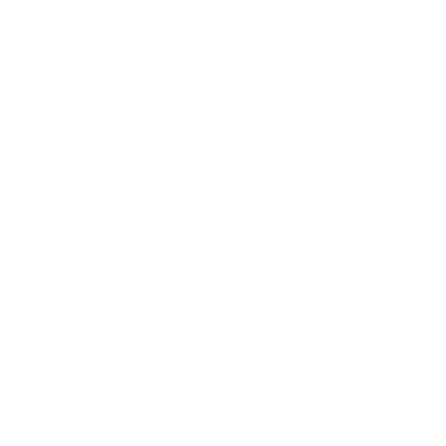

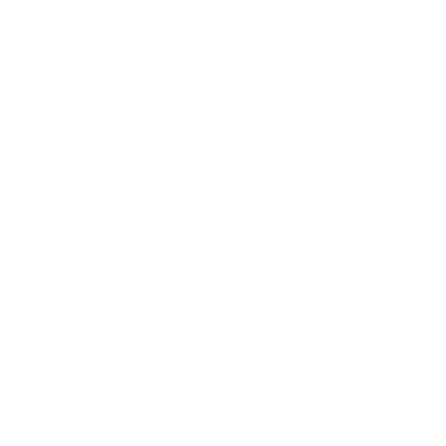

In [7]:
for i,s in enumerate(valid_sessions):  
    image_recs = coll.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
    num_drawings = image_recs.count()
    if num_drawings > 2 :
        print 'Great! Number of drawings made by this person: {}'.format(image_recs.count())        
        ### now try looping through all images made during this session and render out
        try:
            image_recs = coll.find({'$and': [{'time': {'$gt': time_threshold}}, {'sessionId':s}, {'dataType':'finalImage'}]}).sort('time')    
            for imrec in image_recs:         
                if imrec['category'] in practice_categories: # only save practice category trials
                    stroke_recs = coll.find({'$and': [{'time': {'$gt': time_threshold}}, 
                                                      {'sessionId':s}, 
                                                      {'dataType':'stroke'},
                                                      {'trialNum': imrec['trialNum']}]}).sort('time')  
                    ## check to make sure that there is at least one stroke! 
                    assert stroke_recs.count()>0

                    ## some handy metadata for writing out the sketch PNG filename
                    trial_num = stroke_recs[0]['trialNum']
                    category = stroke_recs[0]['category']
                    session_id = stroke_recs[0]['sessionId']
                    age = stroke_recs[0]['age']

                    ## now make an svg list!
                    svg_list = make_svg_list(stroke_recs)

                    ## now get me some verts and codes!
                    Verts, Codes = get_verts_and_codes(svg_list)

                    ## now render out your cumulative sketches and save out as pngs!
                    render_and_save(Verts,
                                    Codes,
                                    line_width=5,
                                    imsize=6,
                                    canvas_size=809,
                                    session_id=session_id,
                                    age=age,
                                    trial_num=trial_num,
                                    category=category)

        except Exception as e:
            print 'Oops, something went wrong! Here is the error:'  
            print e
            pass
